This is analysis is based on the daily reports from the John Hopkins GitHub Repository: https://github.com/CSSEGISandData/COVID-19.

The data in the charts has been normalized both with regard to population and time. The horizontal axes are the number of days since Confirmed occurrences exceed the population for the region divided by ten million. For the linear scale charts, the vertical axes are a multiplier for each day of those occurrences on the first day. The log scale charts are the log base 10 values of the multipliers. This methodology was first proposed by Kevin Drum of Mother Jones who has kept a running account of the COVID-19 trends on his blog: https://www.motherjones.com/kevin-drum/.

The notebook is parameterized for US states, with a special cases for Italy and the Hubei province in China. Add or remove names from the lists to present your charts of interest. Similar to the United States, companion notebooks could be created for states and provinces in other regions.

For a more complete listing of the available global data sources take a look at the COVID-19 dataset clearinghouse: https://asone.ai/polymath/index.php?title=COVID-19_dataset_clearinghouse.

The COVID Tracking project has detailed daily numbers for the US: https://github.com/COVID19Tracking/covid-tracking-data

The CDC tracks estimated deaths in US states: https://data.cdc.gov/api/views/r8kw-7aab/rows.csv?accessType=DOWNLOAD&api_foundry=true

The CDC tracks estimated deaths in US counties: https://data.cdc.gov/api/views/kn79-hsxy/rows.csv?accessType=DOWNLOAD

The US county population and incident data is provided by USAFacts: https://usafacts.org/visualizations/coronavirus-covid-19-spread-map/

Esri has data sets associated with COVID-19: https://coronavirus-disasterresponse.hub.arcgis.com/#get-data

In [1]:
!pip install numpy pandas sodapy tpot

In [3]:
import pandas as pd
pd.set_option('mode.chained_assignment', None)
from sodapy import Socrata
import numpy as np
from datetime import datetime, date, timedelta
from dateutil.relativedelta import relativedelta
import zipfile as zf
import math
import os

List of counties to exclude

In [4]:
county_exclude_locs = ["36061,New York County,NY"]

Translate location name to abbreviation

In [5]:
def _state_loc_abbrev(loc):
    """
    Translate state location name to two character abbreviation
    
    Parameters
    ---------
    loc : string
        State location name
        
    Returns
    -------
    Two character abbreviation
    """
    xlator = {
        "New York" : "NY",
        "New Jersey" : "NJ",
        "Washington" : "WA",
        "California" : "CA",
        "Michigan" : "MI",
        "Massachusetts" : "MA",
        "Illinois" : "IL",
        "Florida" : "FL",
        "Louisiana" : "LA",
        "Pennsylvania" : "PA",
        "Colorado" : "CO",
        "Georgia" : "GA",
        "Texas" : "TX",
        "Connecticut" : "CT",
        "North Carolina" : "NC",
        "Indiana" : "IN",
        "Alabama" : "AL",
        "Alaska" : "AK",
        "Arizona" : "AZ",
        "Arkansas" : "AR",
        "Delaware" : "DE",
        "District of Columbia" : "DC",
        "Hawaii" : "HI",
        "Idaho" : "ID",
        "Iowa" : "IA",
        "Kansas" : "KS",
        "Kentucky" : "KY",
        "Maine" : "ME",
        "Maryland" : "MD",
        "Minnesota" : "MN",
        "Mississippi" : "MS",
        "Missouri" : "MO",
        "Montana" : "MT",
        "Nebraska" : "NE",
        "Nevada" : "NV",
        "New Hampshire" : "NH",
        "New Mexico" : "NM",
        "North Dakota" : "ND",
        "Ohio" : "OH",
        "Oklahoma" : "OK",
        "Oregon" : "OR",
        "Rhode Island" : "RI",
        "South Carolina" : "SC",
        "South Dakota" : "SD",
        "Tennessee" : "TN",
        "Utah" : "UT",
        "Vermont" : "VT",
        "Virginia" : "VA",
        "West Virginia" : "WV",
        "Wisconsin" : "WI",
        "Wyoming" : "WY",
    }
    return xlator.get(loc, "")

Generate list of dates

In [6]:
def _date_range(start, end):
    """
    Generate dates in the form: <dd>-<mm>-<yyyy>

    Parameters
    ----------
    start : string
        Start date in range.
    end : string
        End date in range.

    Returns
    -------
    Sequence of dates.

    """
    start_date = start.split('-')
    sdate = date(int(start_date[2]), int(start_date[0]), int(start_date[1]))
    end_date = end.split('-')
    edate = date(int(end_date[2]), int(end_date[0]), int(end_date[1]))
    
    delta = edate - sdate
    
    i = 0
    while i < delta.days + 1:
        idate = sdate + timedelta(days = i)
        day = idate.strftime("%m-%d-%Y")
        yield day
        i += 1

Extract incidents from John Hopkins daily reports

In [7]:
def _jh_trend(trend_report, scope, category, locs, trend):
    """
    Parameters:
        trend_report - raw data organized by date: dictionary of dataframes
        scope - level of analysis, e.g. country (0), state (1), county(2): integer
        category - type of trend, e.g. Confirmed, Deaths, Recovered, Active: string
        locs - locations to analyze, e.g. Italy, etc.: list of strings
        trend - trend tables: dictionary of dataframes
    """
    for loc in locs:
        if scope == 2:
            loc_split = loc.split(',')
            county_fips = int(loc_split[0])
            county_name = loc_split[1]
            state_abbrev = loc_split[2]
            t = trend[category][(trend[category]['FIPS'] == county_fips)]['Threshold']
        else:
            t = trend[category][(trend[category]['Location'] == loc)]['Threshold']

        incident_threshold = t.item()
        
        j = 0
        for idate in _date_range(start, end_date):
            incident_report = trend_report[idate]
            if scope == 2 and not "FIPS" in incident_report.columns:
                continue
                
            total_incidents = 0
            
            label = []
            if "Country/Region" in incident_report.columns:
                # Early reports use 'Country/Region' and 'Province/State' column labels
                label.append(incident_report.columns[1])
                label.append(incident_report.columns[0])
            else:
                # later reports use 'Country_Region' and 'Province_State'
                label.append(incident_report.columns[3])
                label.append(incident_report.columns[2])
                label.append(incident_report.columns[0])
                assert label[0] == "Country_Region" and label[1] == "Province_State" and label[2] == "FIPS"
                
            if scope == 2:
                incident_df = incident_report[(incident_report[label[scope]] == county_fips)]
            else:
                incident_df = incident_report[(incident_report[label[scope]] == loc)]
                
            # Early reports do not have all categories
            if incident_df.empty or category not in incident_df.columns:
                continue
            
            if scope == 2:
                series_loc = county_fips
                loc = "{0},{1}".format(county_name, state_abbrev)
            else:
                series_loc = loc
                
                # Reports have changed how they list the United Kingdom
                if loc == "United Kingdom":
                    if len(incident_df) == 0:
                        series_loc = "UK"
                        incident_df = incident_report[(incident_report[label[scope]] == series_loc)]

                # Reports have changed how they list South Korea
                if loc == "South Korea":
                    if len(incident_df) == 0:
                        series_loc = "Republic of Korea"
                        incident_df = incident_report[(incident_report[label[scope]] == series_loc)]
                    if len(incident_df) == 0:
                        series_loc = "Korea, South"
                        incident_df = incident_report[(incident_report[label[scope]] == series_loc)]
              
            incidents_by_scope = incident_report.groupby([label[scope]])[category].sum()
            incident_series = incidents_by_scope.loc[[series_loc]]
            if incident_series.size == 0:
                continue

            total_incidents = incident_series.tolist()[0]

            try:
                # Replace state incidents with available data from CSSE US tracking
                if scope == 1 and idate in daily_us_report.keys():
                    us_day_report = daily_us_report[idate]
                    daily_series = us_day_report[(us_day_report[label[scope]] == loc)]
                    if len(daily_series) > 0 and category in daily_series.columns:
                        alt_incidents = daily_series[category].item()
                        if not np.isnan(alt_incidents):
                            total_incidents = alt_incidents
            except NameError:
                # Dataframe daily_us_report not available in this notebook
                pass
                    
            try:
                # Collect recovered data from CTP US tracking
                if category == "Recovered" and total_incidents == 0:
                    state_abbrev = _loc_abbrev(loc)
                    if len(state_abbrev) > 0 and idate in ctp_tracking.keys():
                        state_series = ctp_tracking[idate][(ctp_tracking[idate]["state"] == state_abbrev)]
                        if len(state_series) > 0:
                            recovered = state_series["recovered"].item()
                            if not np.isnan(recovered):
                                total_incidents = int(recovered)
            except NameError:
                # Dataframe ctp_tracking not available in this notebook
                pass
                
            # Many reports do not have "Active" data, ignore negative incidents
            if category == "Active" and (category not in incident_report.columns or total_incidents <= 0):
                # Calculate as: confirmed - (deaths + recovered)
                confirmed_series = trend["Confirmed"].loc[(trend["Confirmed"]['Location'] == loc), "Day{0:d}".format(j + 1)]
                confirmed = incident_threshold * confirmed_series.item()
                deaths_series = trend["Deaths"].loc[(trend["Deaths"]['Location'] == loc), "Day{0:d}".format(j + 1)]
                deaths = incident_threshold * deaths_series.item()
                recovered_series = trend["Recovered"].loc[(trend["Recovered"]['Location'] == loc), "Day{0:d}".format(j + 1)]
                recovered = incident_threshold * recovered_series.item()
                total_incidents = confirmed - (deaths + recovered)

            # Record trends for all categories when Confirmed threshold is met
            tc = "Confirmed"
            cur_date = idate.split('-')
            cdate = date(int(cur_date[2]), int(cur_date[0]), int(cur_date[1]))
            match_date = trend[category].loc[(trend[category]['Location'] == loc), "Start Date"].item()
            if len(match_date) == 0:
                # Initialize the start date for category
                conf_date = trend[tc].loc[(trend[tc]['Location'] == loc), "Start Date"].item()
                if category == tc and incident_threshold < total_incidents:
                    trend[category].loc[(trend[category]['Location'] == loc), "Start Date"] = idate
                elif len(match_date) <= 0:
                    trend[category].loc[(trend[category]['Location'] == loc), "Start Date"] = conf_date
            
            match_date = trend[category].loc[(trend[category]['Location'] == loc), "Start Date"].item()
            if len(match_date) > 0:
                match_date = match_date.split('-')
                mdate = date(int(match_date[2]), int(match_date[0]), int(match_date[1]))
                if cdate >= mdate:
                    j += 1
                    trend[category].loc[(trend[category]['Location'] == loc),
                                               "Day{0:d}".format(j)] = total_incidents / incident_threshold
                    
        trend[category].loc[(trend[category]['Location'] == loc), "Last Day"] = j

Extract incidents from USAFacts county daily reports

In [8]:
def _county_trend(trend_report, scope, category, locs, trend):
    """
    Parameters:
        trend_report - raw data organized by date in columns: dataframe
        scope - level of analysis, e.g. county (2): integer
        category - type of trend, e.g. Confirmed, Deaths: string
        locs - locations to analyze, e.g. Randolph County,GA; etc.: list of strings
        trend - trend tables: dictionary of dataframes
    """
    if scope != 2:
        return
    
    for loc in locs:
        loc_split = loc.split(',')
        county_fips = int(loc_split[0])
        county_name = loc_split[1].lower()
        state_abbrev = loc_split[2]
        county_df = trend_report[(trend_report["County Name"].str.lower() == county_name) &
                                    (trend_report["State"] == state_abbrev)]
        t = trend[category][(trend[category]["FIPS"] == county_fips)]['Threshold']
        incident_threshold = t.item()
        
        j = 0      
        for idate in _date_range(start, end_date):
            idate_split = idate.split('-')
            usaf_date = "{0}/{1}/{2}".format(int(idate_split[0]), int(idate_split[1]), int(idate_split[2]) - 2000)
            if not usaf_date in county_df.columns:
                break
            total_incidents = county_df[usaf_date].tolist()[0]
                
            # Record trends for all categories when Confirmed threshold is met
            tc = "Confirmed"
            cur_date = idate.split('-')
            cdate = date(int(cur_date[2]), int(cur_date[0]), int(cur_date[1]))
            match_date = trend[category].loc[(trend[category]["FIPS"] == county_fips), "Start Date"].item()
            if len(match_date) == 0:
                # Initialize the start date for category
                conf_date = trend[tc].loc[(trend[tc]["FIPS"] == county_fips), "Start Date"].item()
                if category == tc and incident_threshold < total_incidents:
                    trend[category].loc[(trend[category]["FIPS"] == county_fips), "Start Date"] = idate
                elif len(match_date) <= 0:
                    trend[category].loc[(trend[category]["FIPS"] == county_fips), "Start Date"] = conf_date
            
            match_date = trend[category].loc[(trend[category]["FIPS"] == county_fips), "Start Date"].item()
            if len(match_date) > 0:
                match_date = match_date.split('-')
                mdate = date(int(match_date[2]), int(match_date[0]), int(match_date[1]))
                if cdate >= mdate:
                    j += 1
                    trend[category].loc[(trend[category]["FIPS"] == county_fips),
                                               "Day{0:d}".format(j)] = total_incidents / incident_threshold
                    
        trend[category].loc[(trend[category]["FIPS"] == county_fips), "Last Day"] = j

Start and ending dates for reports

In [9]:
start = "01-22-2020"
end = date.today().strftime("%m-%d-%Y")

Read daily records from John Hopkins. Clone the git repository: https://github.com/CSSEGISandData/COVID-19. Zip the COVID-19\csse_covid_19_data\csse_covid_19_daily_reports directory and upload the .zip file to the Jupyter folder containing the notebook.

In [10]:
# Remove reports
report_dir = "csse_covid_19_daily_reports"
try:
    os.rmdir(report_dir)
except:
    pass
    
# Extract files from zip archive
files = zf.ZipFile("csse_covid_19_daily_reports.zip", 'r')
files.extractall("")
files.close()

days = 0
daily_report = {}
for iday in _date_range(start, end):
    try:
        daily_report[iday] = pd.read_csv("csse_covid_19_daily_reports/{}.csv".format(iday))
        end_date = iday
        days += 1
    except:
        pass

Collect US county FIPS and associated John Hopkins location names and deaths from the most recent report to create FIPS table.

In [11]:
last_report = daily_report[end_date]
last_report_us = last_report[(last_report["Country_Region"] == "US")]
# Remove null values
last_report_us = last_report_us.dropna(how='any',axis=0)
# Convert FIPS column to integer
last_report_us = last_report_us.astype({"FIPS" : int})
# Create FIPS table
fips = last_report_us[["FIPS", "Admin2", "Province_State", "Deaths"]]
# Rename columns
fips.columns = ["FIPS", "JH_Location", "State", "Deaths"]
# Add state abbreviation column
fips["State_Abbrev"] = fips["State"].apply(_state_loc_abbrev)
# Set FIPS column as the index
fips.set_index("FIPS", inplace = True)

Read US county populations from USAFacts. Upload the file 'covid_county_population_usafacts.csv' from https://usafacts.org/visualizations/coronavirus-covid-19-spread-map/ to the Jupyter folder containing the notebook.

In [12]:
us_county_population = pd.read_csv('covid_county_population_usafacts.csv')

Add the location names and populations to the FIPS table.

In [13]:
county_fips = us_county_population[["countyFIPS", "County Name", "State", "population"]]
# Remove rows with zero population
county_fips.fillna(0)
county_fips = county_fips[county_fips.population > 0.0]
# Set FIPS column as the index
county_fips.set_index("countyFIPS", inplace = True)
# Add county name to FIPS table
fips["USAF_Location"]  = county_fips["County Name"]
# Add county population to FIPS table
fips["Population"] = county_fips["population"]

Read daily county confirmed records from USAFacts. Upload the file 'covid_confirmed_usafacts.csv' from https://usafacts.org/visualizations/coronavirus-covid-19-spread-map/ to the Jupyter folder containing the notebook.

In [77]:
us_county_confirmed_report = pd.read_csv('covid_confirmed_usafacts.csv')

Read daily county death records from USAFacts. Upload the file 'covid_deaths_usafacts.csv' from https://usafacts.org/visualizations/coronavirus-covid-19-spread-map/ to the Jupyter folder containing the notebook.

In [15]:
us_county_deaths_report = pd.read_csv('covid_deaths_usafacts.csv')

Read weekly death data from CDC. Upload the file 'Provisional_COVID-19_Death_Counts_in_the_United_States_by_County.csv' from https://data.cdc.gov/api/views/kn79-hsxy/rows.csv?accessType=DOWNLOAD to the Jupyter folder containing the notebook. Add county names to FIPS table.

In [16]:
cdc_2020_deaths = pd.read_csv('Provisional_COVID-19_Death_Counts_in_the_United_States_by_County.csv')
cdc_fips = cdc_2020_deaths[["FIPS County Code", "County name", "State"]]
# Set FIPS column as the index
cdc_fips.set_index("FIPS County Code", inplace = True)
fips["CDC_Location"] = cdc_fips["County name"]

Extract first and last week in CDC deaths data.

In [17]:
cdc_2020_deaths["County"] = cdc_2020_deaths["County name"] + ", " + cdc_2020_deaths["State"]
start_cdc_week = cdc_2020_deaths["First week"][0]
end_cdc_week = cdc_2020_deaths["Last week"][0]

Read monthly 2018 death data from CDC. Upload the file 'CDC_2018_All_Causes_Death_by_County_and_Month.csv' generated from CDC WONDER (https://wonder.cdc.gov/ucd-icd10.html) and converted to .csv to the Jupyter folder containing the notebook.

In [18]:
cdc_2018_deaths = pd.read_csv('CDC_2018_All_Causes_Death_by_County_and_Month.csv')

Collect monthly CDC total deaths from 2018 for the time period corresponding to the 2020 data.

In [19]:
start_cdc_week_split = start_cdc_week.split('/')
start_month_str = "{0}/1/{1}".format(int(start_cdc_week_split[0]), int(start_cdc_week_split[2]) - 2)
end_cdc_week_split = end_cdc_week.split('/')
end_month_str = "{0}/1/{1}".format(int(end_cdc_week_split[0]), int(end_cdc_week_split[2]) - 2)
monthly_2018_deaths = cdc_2018_deaths[(cdc_2018_deaths["Date"] >= start_month_str) \
                                        & (cdc_2018_deaths["Date"] <= end_month_str)]
pd.options.mode.chained_assignment = None
monthly_2018_deaths.loc["Deaths"] = pd.to_numeric(monthly_2018_deaths["Deaths"])
cdc_2018_deaths_by_county = monthly_2018_deaths.groupby(["County Code", "County"])["Deaths"].sum()

Collect weekly CDC total deaths from 2020 accumulated so far

In [20]:
cdc_us_deaths_by_county = cdc_2020_deaths.groupby(["FIPS County Code","County"])["Deaths from All Causes"].sum()
cdc_county_list = []
for i, deaths in enumerate(cdc_us_deaths_by_county.iteritems()):
    county_fips = deaths[0][0]
    deaths_2020 = int(deaths[1])
    try:
        county = fips.loc[county_fips]
    except:
        # New York City counties are included in City data
        continue
    county_name = county[0]
    state_abbrev = county[3]
    county_loc = county[4]
    # Subtract the COVID-19 deaths before comparing with 2018
    covid_deaths_2020 = int(county[2])
    deaths_2020 -= covid_deaths_2020
    pop = county[5]
    # Divide by one thousand
    pop = float(pop) / 10**3
    deaths_2018 = cdc_2018_deaths_by_county[county_fips].tolist()[0]
    cdc_county_list.append(
        {"Location" : "{0},{1},{2}".format(county_fips, county_loc, state_abbrev),
         "2018 Accum Deaths" : deaths_2018, "2020 Accum Deaths" : deaths_2020, "Pop" : pop / 10.0})

# Create dataframe from list of dictionaries
cdc_county_report = pd.DataFrame(cdc_county_list)
# Add accumulated deaths ratio column
cdc_county_report["2020/2018"] = cdc_county_report["2020 Accum Deaths"] / cdc_county_report["2018 Accum Deaths"]

Determine top 10 US county hotspots based on most recent total per capita COVID-19 deaths in John Hopkins data.

In [21]:
last_deaths_report_by_county = last_report_us.groupby(["Province_State","Admin2","FIPS"])["Deaths"].sum()
jh_county_deaths_list = []
for i, deaths in enumerate(last_deaths_report_by_county.iteritems()):
    county_fips = deaths[0][2]
    county_deaths = deaths[1]
    try:
        county = fips.loc[county_fips]
    except:
        continue
    county_name = county[0]
    state_abbrev = county[3]
    county_loc = county[4]
    pop = county[5]
    # Divide by one thousand
    pop = float(pop) / 10**3
    # Compose list of dictionaries for locations
    jh_county_deaths_list.append(
            {"Location" : "{0},{1},{2}".format(county_fips, county_loc, state_abbrev),
             "Deaths" : county_deaths, "Pop" : pop / 10.0})
    
# Create dataframe from list of dictionaries
jh_county_deaths_report = pd.DataFrame(jh_county_deaths_list)
# Add deaths per 10K population column
jh_county_deaths_report["Deaths/10K"] = jh_county_deaths_report["Deaths"] / jh_county_deaths_report["Pop"]
jh_county_deaths_report = jh_county_deaths_report.sort_values("Deaths/10K", ascending = False)
jh_county_deaths_highest = jh_county_deaths_report["Deaths/10K"].tolist()[0]
jh_county_deaths_report["Normalized"] = jh_county_deaths_report["Deaths/10K"].apply(lambda x: x / jh_county_deaths_highest)
print(jh_county_deaths_report["Location"].tolist()[:20])

['13141,Hancock County,GA', '48261,Kenedy County,TX', '51595,Emporia city,VA', '51640,Galax city,VA', '13243,Randolph County,GA', '13273,Terrell County,GA', '22037,East Feliciana Parish,LA', '35031,McKinley County,NM', '28099,Neshoba County,MS', '36005,Bronx County,NY', '28051,Holmes County,MS', '31135,Perkins County,NE', '13165,Jenkins County,GA', '13099,Early County,GA', '36081,Queens County,NY', '48047,Brooks County,TX', '28125,Sharkey County,MS', '28023,Clarke County,MS', '28083,Leflore County,MS', '36047,Kings County,NY']


Determine top 20 US county hotspots based on most recent total per capita COVID-19 confirmed in John Hopkins data.

In [22]:
last_confirmed_report_by_county = last_report_us.groupby(["Province_State","Admin2","FIPS"])["Confirmed"].sum()
jh_county_confirmed_list = []
for i, confirmed in enumerate(last_confirmed_report_by_county.iteritems()):
    county_fips = confirmed[0][2]
    county_confirmed = confirmed[1]
    try:
        county = fips.loc[county_fips]
    except:
        continue
    county_name = county[0]
    state_abbrev = county[3]
    county_loc = county[4]
    pop = county[5]
    # Divide by one thousand
    pop = float(pop) / 10**3
    # Compose list of dictionaries for locations
    jh_county_confirmed_list.append(
            {"Location" : "{0},{1},{2}".format(county_fips, county_loc, state_abbrev),
             "Confirmed" : county_confirmed, "Pop" : pop / 10.0})
    
# Create dataframe from list of dictionaries
jh_county_confirmed_report = pd.DataFrame(jh_county_confirmed_list)
# Add confirmed per 10K population column
jh_county_confirmed_report["Confirmed/10K"] = jh_county_confirmed_report["Confirmed"] / jh_county_confirmed_report["Pop"]
jh_county_confirmed_report = jh_county_confirmed_report.sort_values("Confirmed/10K", ascending = False)
jh_county_confirmed_highest = jh_county_confirmed_report["Confirmed/10K"].tolist()[0]
jh_county_confirmed_report["Normalized"] = \
    jh_county_confirmed_report["Confirmed/10K"].apply(lambda x: x / jh_county_confirmed_highest)
print(jh_county_confirmed_report["Location"].tolist()[:20])

['5079,Lincoln County,AR', '13053,Chattahoochee County,GA', '47169,Trousdale County,TN', '12067,Lafayette County,FL', '47095,Lake County,TN', '5077,Lee County,AR', '31043,Dakota County,NE', '19021,Buena Vista County,IA', '5017,Chicot County,AR', '27105,Nobles County,MN', '22037,East Feliciana Parish,LA', '47181,Wayne County,TN', '20057,Ford County,KS', '22065,Madison Parish,LA', '22035,East Carroll Parish,LA', '20175,Seward County,KS', '28055,Issaquena County,MS', '13259,Stewart County,GA', '40139,Texas County,OK', '31037,Colfax County,NE']


Determine top ten US hotspots based on accumulated per capita total death increase in CDC data.

In [23]:
# Add deaths per 10K population column
cdc_county_report["Deaths/10K"] = cdc_county_report["2020 Accum Deaths"] / cdc_county_report["Pop"]
cdc_county_report = cdc_county_report.sort_values("2020/2018", ascending = False)
# Normalize to highest
cdc_county_highest = cdc_county_report["2020/2018"].tolist()[0]
cdc_county_report["Normalized"] = cdc_county_report["2020/2018"].apply(lambda x: x / cdc_county_highest)
cdc_county_locs = cdc_county_report["Location"].tolist()[:20]
print(cdc_county_locs)

['5101,Newton County,AR', '31135,Perkins County,NE', '42093,Montour County,PA', '51595,Emporia city,VA', '51630,Fredericksburg City,VA', '51840,Winchester city,VA', '51540,Charlottesville City,VA', '48425,Somervell County,TX', '51775,Salem city,VA', '19103,Johnson County,IA', '13235,Pulaski County,GA', '28081,Lee County,MS', '54061,Monongalia County,WV', '5031,Craighead County,AR', '28049,Hinds County,MS', '28071,Lafayette County,MS', '29145,Newton County,MO', '31081,Hamilton County,NE', '47113,Madison County,TN', '28035,Forrest County,MS']


Determine top 10 US county hotspots based on most recent total per capita COVID-19 deaths in USAFacts data.

In [24]:
county_deaths_list = []
for i, deaths in enumerate(us_county_deaths_report.iterrows()):
    county_fips = deaths[1][0]
    county_deaths = deaths[1][-1]
    try:
        county = fips.loc[county_fips]
    except:
        # Skip Statewide Unallocated
        continue
    county_name = county[0]
    state_abbrev = county[3]
    county_loc = county[4]
    pop = county[5]
    # Divide by one thousand
    pop = float(pop) / 10**3
    county_deaths_list.append({"Location" : "{0},{1},{2}".format(county_fips, county_loc, state_abbrev),
                        "Deaths" : float(county_deaths),
                        "Pop" : pop / 10.0})

usaf_county_deaths_report = pd.DataFrame(county_deaths_list)
# Add deaths per 10K population column
usaf_county_deaths_report["Deaths/10K"] = usaf_county_deaths_report["Deaths"] / usaf_county_deaths_report["Pop"]
usaf_county_deaths_report = usaf_county_deaths_report.sort_values("Deaths/10K", ascending = False)
usaf_county_deaths_highest = usaf_county_deaths_report["Deaths/10K"].tolist()[0]
usaf_county_deaths_report["Normalized"] = \
    usaf_county_deaths_report["Deaths/10K"].apply(lambda x: x / usaf_county_deaths_highest)
us_county_deaths_locs = usaf_county_deaths_report["Location"].tolist()[:20]
print(us_county_deaths_locs)

['13141,Hancock County,GA', '48261,Kenedy County,TX', '51595,Emporia city,VA', '51640,Galax city,VA', '13243,Randolph County,GA', '13273,Terrell County,GA', '22037,East Feliciana Parish,LA', '35031,McKinley County,NM', '28099,Neshoba County,MS', '36005,Bronx County,NY', '28051,Holmes County,MS', '31135,Perkins County,NE', '13165,Jenkins County,GA', '13099,Early County,GA', '36081,Queens County,NY', '48047,Brooks County,TX', '28125,Sharkey County,MS', '28023,Clarke County,MS', '28083,Leflore County,MS', '36047,Kings County,NY']


Determine top 20 US county hotspots based on most recent total per capita COVID-19 confirmed in USAFacts data.

In [25]:
county_confirmed_list = []
for i, confirmed in enumerate(us_county_confirmed_report.iterrows()):
    county_fips = confirmed[1][0]
    county_confirmed = confirmed[1][-1]
    try:
        county = fips.loc[county_fips]
    except:
        # Skip Statewide Unallocated
        continue
    county_name = county[0]
    state_abbrev = county[3]
    county_loc = county[4]
    pop = county[5]
    # Divide by one thousand
    pop = float(pop) / 10**3
    county_confirmed_list.append({"Location" : "{0},{1},{2}".format(county_fips, county_loc, state_abbrev),
                        "Confirmed" : float(county_confirmed),
                        "Pop" : pop / 10.0})

usaf_county_confirmed_report = pd.DataFrame(county_confirmed_list)
# Add confirmed per 10K population column
usaf_county_confirmed_report["Confirmed/10K"] = usaf_county_confirmed_report["Confirmed"] / usaf_county_confirmed_report["Pop"]
usaf_county_confirmed_report = usaf_county_confirmed_report.sort_values("Confirmed/10K", ascending = False)
usaf_county_confirmed_highest = usaf_county_confirmed_report["Confirmed/10K"].tolist()[0]
usaf_county_confirmed_report["Normalized"] = \
    usaf_county_confirmed_report["Confirmed/10K"].apply(lambda x: x / usaf_county_confirmed_highest)
us_county_confirmed_locs = usaf_county_confirmed_report["Location"].tolist()[:20]
print(us_county_confirmed_locs)

['5079,Lincoln County,AR', '13053,Chattahoochee County,GA', '47169,Trousdale County,TN', '12067,Lafayette County,FL', '47095,Lake County,TN', '5077,Lee County,AR', '31043,Dakota County,NE', '19021,Buena Vista County,IA', '5017,Chicot County,AR', '27105,Nobles County,MN', '22037,East Feliciana Parish,LA', '47181,Wayne County,TN', '20057,Ford County,KS', '22065,Madison Parish,LA', '22035,East Carroll Parish,LA', '28055,Issaquena County,MS', '13259,Stewart County,GA', '20175,Seward County,KS', '40139,Texas County,OK', '31037,Colfax County,NE']


Combine three top 10 deaths lists

In [26]:
county_deaths_report = pd.concat([cdc_county_report, jh_county_deaths_report, usaf_county_deaths_report], sort = False)
county_deaths_report = county_deaths_report.sort_values("Normalized", ascending = False)
us_top_deaths_locs = county_deaths_report["Location"][:40].tolist()
us_total_deaths_locs = us_top_deaths_locs
# Remove any duplicates
us_top_deaths_locs = list(dict.fromkeys(us_top_deaths_locs))
us_total_deaths_locs = list(dict.fromkeys(us_total_deaths_locs))
# Exclude known locations
for loc in county_exclude_locs:
    try:
        us_top_deaths_locs.remove(loc)
    except:
        continue
print(us_top_deaths_locs)

['13141,Hancock County,GA', '48261,Kenedy County,TX', '51595,Emporia city,VA', '51640,Galax city,VA', '13243,Randolph County,GA', '13273,Terrell County,GA', '22037,East Feliciana Parish,LA', '35031,McKinley County,NM', '28099,Neshoba County,MS', '36005,Bronx County,NY', '28051,Holmes County,MS', '31135,Perkins County,NE', '13165,Jenkins County,GA', '13099,Early County,GA', '36081,Queens County,NY', '48047,Brooks County,TX', '28125,Sharkey County,MS', '28023,Clarke County,MS', '28083,Leflore County,MS', '36047,Kings County,NY']


Combine two top 20 confirmed lists

In [27]:
county_confirmed_report = pd.concat([jh_county_confirmed_report, usaf_county_confirmed_report])
county_confirmed_report = county_confirmed_report.sort_values("Normalized", ascending = False)
us_top_confirmed_locs = county_confirmed_report["Location"][:40].tolist()
us_total_confirmed_locs = us_top_confirmed_locs
# Remove any duplicates
us_top_confirmed_locs = list(dict.fromkeys(us_top_confirmed_locs))
us_total_confirmed_locs = list(dict.fromkeys(us_total_confirmed_locs))
# Exclude known locations
for loc in county_exclude_locs:
    try:
        us_top_confirmed_locs.remove(loc)
    except:
        continue
print(us_top_confirmed_locs)

['5079,Lincoln County,AR', '13053,Chattahoochee County,GA', '47169,Trousdale County,TN', '12067,Lafayette County,FL', '47095,Lake County,TN', '5077,Lee County,AR', '31043,Dakota County,NE', '19021,Buena Vista County,IA', '5017,Chicot County,AR', '27105,Nobles County,MN', '22037,East Feliciana Parish,LA', '47181,Wayne County,TN', '20057,Ford County,KS', '22065,Madison Parish,LA', '22035,East Carroll Parish,LA', '20175,Seward County,KS', '28055,Issaquena County,MS', '13259,Stewart County,GA', '40139,Texas County,OK', '31037,Colfax County,NE']


Data frame with United States county incident thresholds (per 10 million population) followed by placeholders for daily numbers

In [28]:
def _add_county_row(days, us_incidents, i, loc):
    global fips
    split_loc = loc.split(',')
    county_fips = int(split_loc[0])
    county_name = split_loc[1]
    state_abbrev = split_loc[2]
    try:
        county = fips.loc[county_fips]
    except:
        print("Missing FIPS:", loc)
        return
    pop = county[5]
    pop = float(pop) / 10**3
    us_incidents.loc[i] = [county_fips] + ["{0},{1}".format(county_name, state_abbrev)] + \
        [pop /10.0] + [""] + [0] + [0.0 for i in range(days)]

In [29]:
usaf_county_confirmed_trend = {}
usaf_county_confirmed_trend['Confirmed'] = pd.DataFrame(None, columns = ["FIPS", "Location", "Threshold", "Start Date", "Last Day"] +
                                         ["Day" + "{0:d}".format(i+1) for i in range(days)])
usaf_county_confirmed_trend['Deaths'] = pd.DataFrame(None, columns = ["FIPS", "Location", "Threshold", "Start Date", "Last Day"] +
                                         ["Day" + "{0:d}".format(i+1) for i in range(days)])

jh_county_confirmed_trend = {}
jh_county_confirmed_trend['Confirmed'] = pd.DataFrame(None, columns = ["FIPS", "Location", "Threshold", "Start Date", "Last Day"] +
                                         ["Day" + "{0:d}".format(i+1) for i in range(days)])
jh_county_confirmed_trend['Deaths'] = pd.DataFrame(None, columns = ["FIPS", "Location", "Threshold", "Start Date", "Last Day"] +
                                         ["Day" + "{0:d}".format(i+1) for i in range(days)])
jh_county_confirmed_trend['Recovered'] = pd.DataFrame(None, columns = ["FIPS", "Location", "Threshold", "Start Date", "Last Day"] +
                                         ["Day" + "{0:d}".format(i+1) for i in range(days)])
jh_county_confirmed_trend['Active'] = pd.DataFrame(None, columns = ["FIPS", "Location", "Threshold", "Start Date", "Last Day"] +
                                         ["Day" + "{0:d}".format(i+1) for i in range(days)])

i = 0
for loc in us_total_confirmed_locs:
    _add_county_row(days, usaf_county_confirmed_trend['Confirmed'], i, loc)
    _add_county_row(days, usaf_county_confirmed_trend['Deaths'], i, loc)

    _add_county_row(days, jh_county_confirmed_trend['Confirmed'], i, loc)
    _add_county_row(days, jh_county_confirmed_trend['Deaths'], i, loc)
    _add_county_row(days, jh_county_confirmed_trend['Recovered'], i, loc)
    _add_county_row(days, jh_county_confirmed_trend['Active'], i, loc)
    i += 1

In [30]:
usaf_county_deaths_trend = {}
usaf_county_deaths_trend['Confirmed'] = pd.DataFrame(None, columns = ["FIPS", "Location", "Threshold", "Start Date", "Last Day"] +
                                         ["Day" + "{0:d}".format(i+1) for i in range(days)])
usaf_county_deaths_trend['Deaths'] = pd.DataFrame(None, columns = ["FIPS", "Location", "Threshold", "Start Date", "Last Day"] +
                                         ["Day" + "{0:d}".format(i+1) for i in range(days)])

jh_county_deaths_trend = {}
jh_county_deaths_trend['Confirmed'] = pd.DataFrame(None, columns = ["FIPS", "Location", "Threshold", "Start Date", "Last Day"] +
                                         ["Day" + "{0:d}".format(i+1) for i in range(days)])
jh_county_deaths_trend['Deaths'] = pd.DataFrame(None, columns = ["FIPS", "Location", "Threshold", "Start Date", "Last Day"] +
                                         ["Day" + "{0:d}".format(i+1) for i in range(days)])
jh_county_deaths_trend['Recovered'] = pd.DataFrame(None, columns = ["FIPS", "Location", "Threshold", "Start Date", "Last Day"] +
                                         ["Day" + "{0:d}".format(i+1) for i in range(days)])
jh_county_deaths_trend['Active'] = pd.DataFrame(None, columns = ["FIPS", "Location", "Threshold", "Start Date", "Last Day"] +
                                         ["Day" + "{0:d}".format(i+1) for i in range(days)])

i = 0
for loc in us_total_deaths_locs:
    _add_county_row(days, usaf_county_deaths_trend['Confirmed'], i, loc)
    _add_county_row(days, usaf_county_deaths_trend['Deaths'], i, loc)

    _add_county_row(days, jh_county_deaths_trend['Confirmed'], i, loc)
    _add_county_row(days, jh_county_deaths_trend['Deaths'], i, loc)
    _add_county_row(days, jh_county_deaths_trend['Recovered'], i, loc)
    _add_county_row(days, jh_county_deaths_trend['Active'], i, loc)
    i += 1

USAF county incidents based on confirmed

In [31]:
_county_trend(us_county_confirmed_report, 2, 'Confirmed', us_total_confirmed_locs, usaf_county_confirmed_trend)
_county_trend(us_county_deaths_report, 2, 'Deaths', us_total_confirmed_locs, usaf_county_confirmed_trend)

USAF county incidents based on deaths

In [32]:
_county_trend(us_county_confirmed_report, 2, 'Confirmed', us_total_deaths_locs, usaf_county_deaths_trend)
_county_trend(us_county_deaths_report, 2, 'Deaths', us_total_deaths_locs, usaf_county_deaths_trend)

John Hopkins county trends based on confirmed

In [66]:
_jh_trend(daily_report, 2, 'Confirmed', us_total_confirmed_locs, jh_county_confirmed_trend)
_jh_trend(daily_report, 2, 'Deaths', us_total_confirmed_locs, jh_county_confirmed_trend)
_jh_trend(daily_report, 2, 'Recovered', us_total_confirmed_locs, jh_county_confirmed_trend)
_jh_trend(daily_report, 2, 'Active', us_total_confirmed_locs, jh_county_confirmed_trend)

John Hopkins county trends based on deaths

In [403]:
_jh_trend(daily_report, 2, 'Confirmed', us_total_deaths_locs, jh_county_deaths_trend)
_jh_trend(daily_report, 2, 'Deaths', us_total_deaths_locs, jh_county_deaths_trend)
_jh_trend(daily_report, 2, 'Recovered', us_total_deaths_locs, jh_county_deaths_trend)
_jh_trend(daily_report, 2, 'Active', us_total_deaths_locs, jh_county_deaths_trend)

In [404]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import statistics

In [405]:
def _subplot_trend(plt, df, loc, color, line_style):
    """
    Parameters:
        plt - plotting object
        df - data frame of data
        loc - location: <FIPS>,<county_name>,<state_abbrev>
        color - line color
        line_style - subplot setting, e.g. '-.'
    """
    loc_split = loc.split(',')
    county_loc = "{0},{1}".format(loc_split[1],loc_split[2])
    loc_df = df.loc[(df["Location"] == county_loc)]
    if loc_df.empty:
        return
    start_date = loc_df["Start Date"].item()
    plot_days = loc_df["Last Day"].item()

    y = []
    for j in range(plot_days):
        daily = loc_df["Day{0:d}".format(j+1)].item()
        y.append(daily)
    x = [j+1 for j in range(len(y))]
    if loc in cdc_county_locs:
        county_loc += "*"
    if len(x) > 0:
        plt.text(x[-1], y[-1], county_loc)
    plt.plot(x, y, line_style, c = color, label = "{0} - {1}".format(start_date, county_loc))

In [406]:
def _subplot_log_trend(plt, df, loc, color, line_style):
    """
    Parameters:
        plt - plotting object
        df - data frame of data
        loc - location: <FIPS>,<county_name>,<state_abbrev>
        color - line color
        line_style - subplot setting, e.g. '-.'
    """
    loc_split = loc.split(',')
    county_loc = "{0},{1}".format(loc_split[1],loc_split[2])
    loc_df = df.loc[(df["Location"] == county_loc)]
    if loc_df.empty:
        return
    start_date = loc_df["Start Date"].item()
    plot_days = loc_df["Last Day"].item()

    y = []
    for j in range(plot_days):
        daily = loc_df["Day{0:d}".format(j+1)].item()
        if daily <= 0.0:
            daily = np.nan
        y.append(math.log(daily, 10))
    y = pd.Series(y).fillna(method = 'ffill').tolist()
    x = [j+1 for j in range(len(y))]
    if loc in cdc_county_locs:
        county_loc += "*"
    if len(x) > 0 and not np.isnan(y[-1]):
        plt.text(x[-1], y[-1], county_loc)
    plt.plot(x, y, line_style, c = color, label = "{0} - {1}".format(start_date, county_loc))

In [407]:
def _plot_trend(db, locs, category, percapita = "10K", leg_loc = "upper left"):
    """
    Parameters:
        db - dictionary of data frames
        locs - list of locations
        category - incident type
        show_reference - True if Hubei, Italy and US should be added to chart
        percaptita - vertical legend label
        leg_loc - legend placement
    """
    plt.figure(figsize = (20,12))
    colors = iter(cm.rainbow(np.linspace(0, 1, len(locs) + 3)))
    for loc in locs:
        color = next(colors)
        _subplot_trend(plt, db[category], loc, color, '-.')

    latest_data = "Latest data: {0}".format(end_date)
    plt.title("COVID-19 {0} ({1})".format(category, latest_data))
    plt.legend(loc = leg_loc, fontsize = 'large', title = "Day01 - Location")
    plt.xlabel("Number of Days Since Threshold")
    plt.ylabel("Linear Growth of Number of {0} per {1} population".format(category, percapita))

In [408]:
def _plot_log_trend(db, locs, category, percapita = "10K", leg_loc = "upper left"):
    plt.figure(figsize=(20,12))
    colors = iter(cm.rainbow(np.linspace(0,1,len(locs) + 3)))
    for loc in locs:
        color = next(colors)
        _subplot_log_trend(plt, db[category], loc, color, '-.')
        
    latest_data = "Latest data: {0}".format(end_date)
    plt.title("COVID-19 {0} ({1})".format(category, latest_data))
    plt.legend(loc = leg_loc, fontsize = 'large', title = "Day01 - Location")
    plt.xlabel("Number of Days Since Threshold")
    plt.ylabel("Log Growth of Number of {0} per {1} population".format(category, percapita))

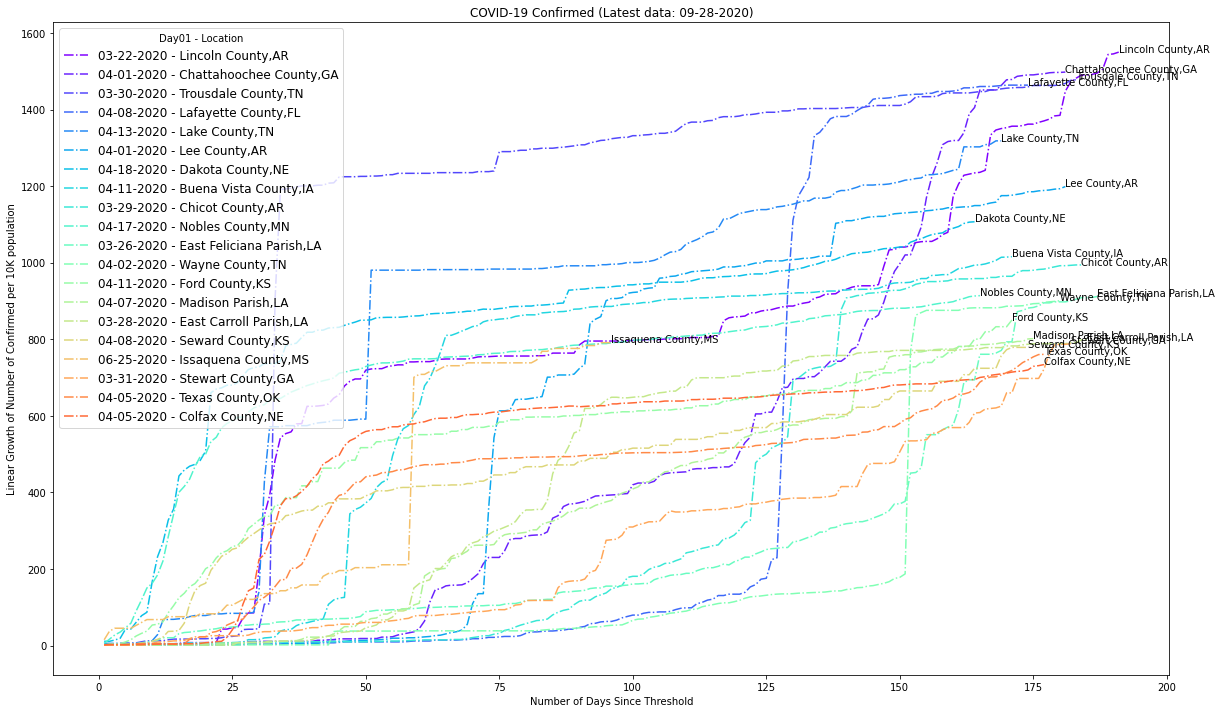

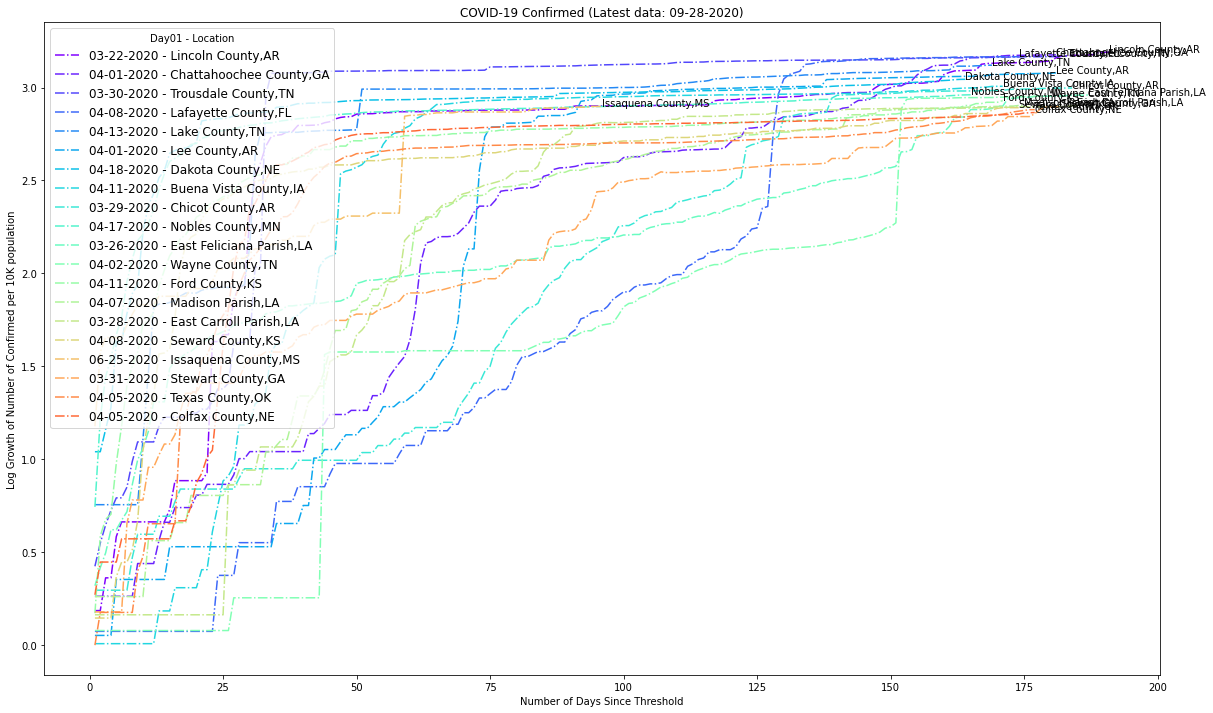

In [409]:
_plot_trend(usaf_county_confirmed_trend, us_top_confirmed_locs, 'Confirmed')
_plot_log_trend(usaf_county_confirmed_trend, us_top_confirmed_locs, 'Confirmed')

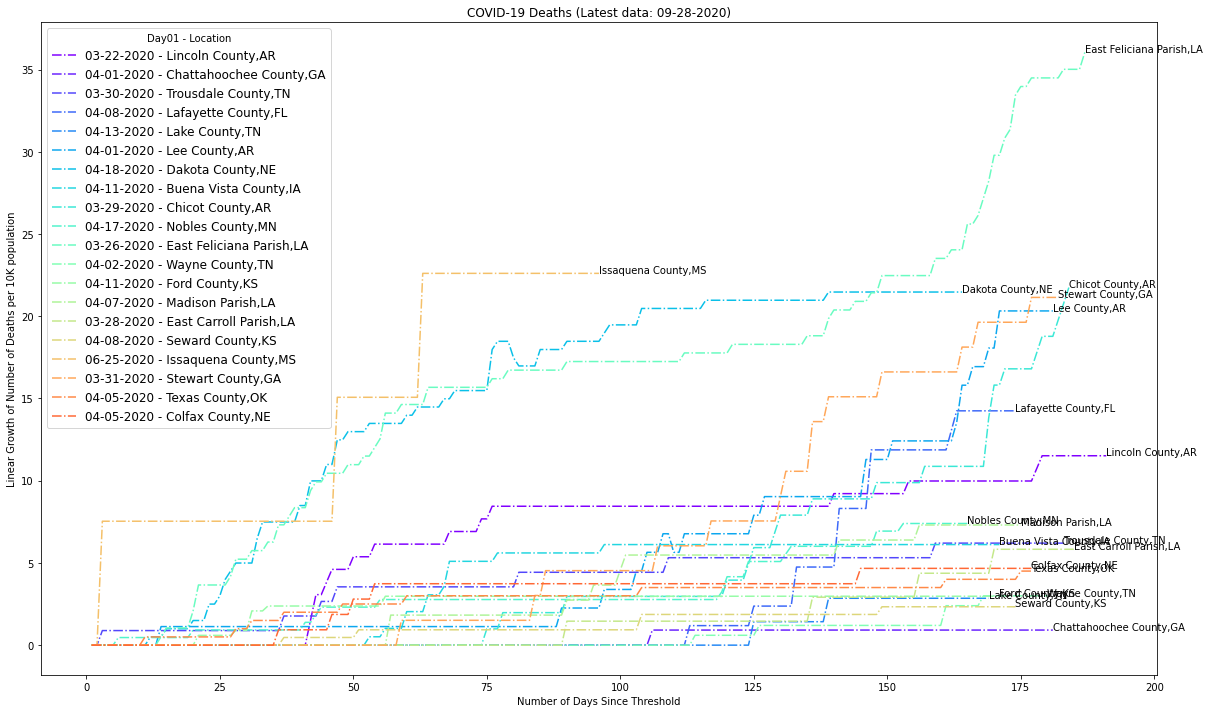

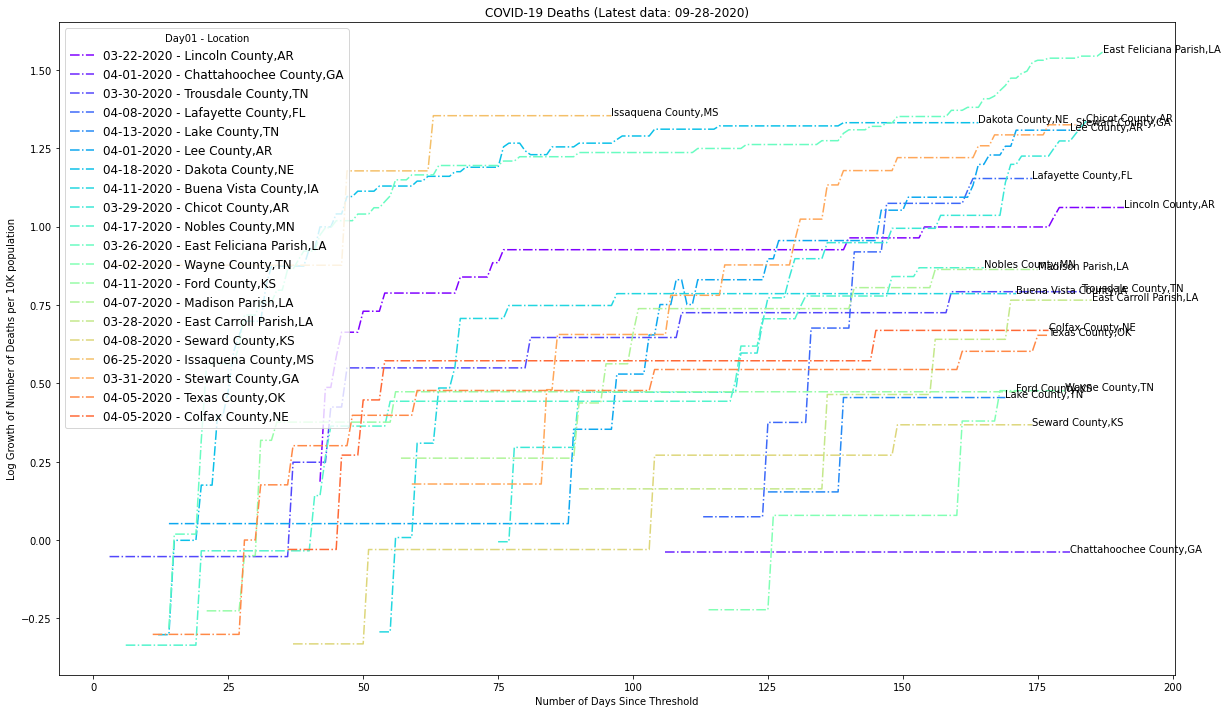

In [410]:
_plot_trend(usaf_county_confirmed_trend, us_top_confirmed_locs, 'Deaths')
_plot_log_trend(usaf_county_confirmed_trend, us_top_confirmed_locs, 'Deaths')

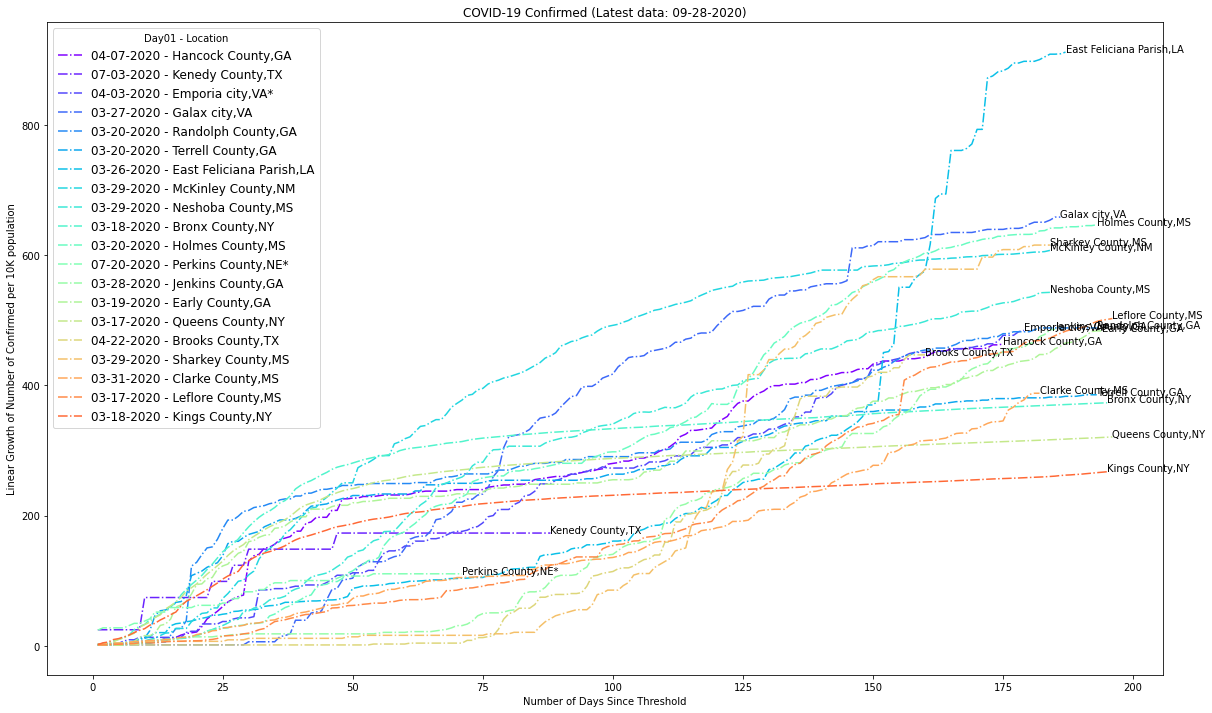

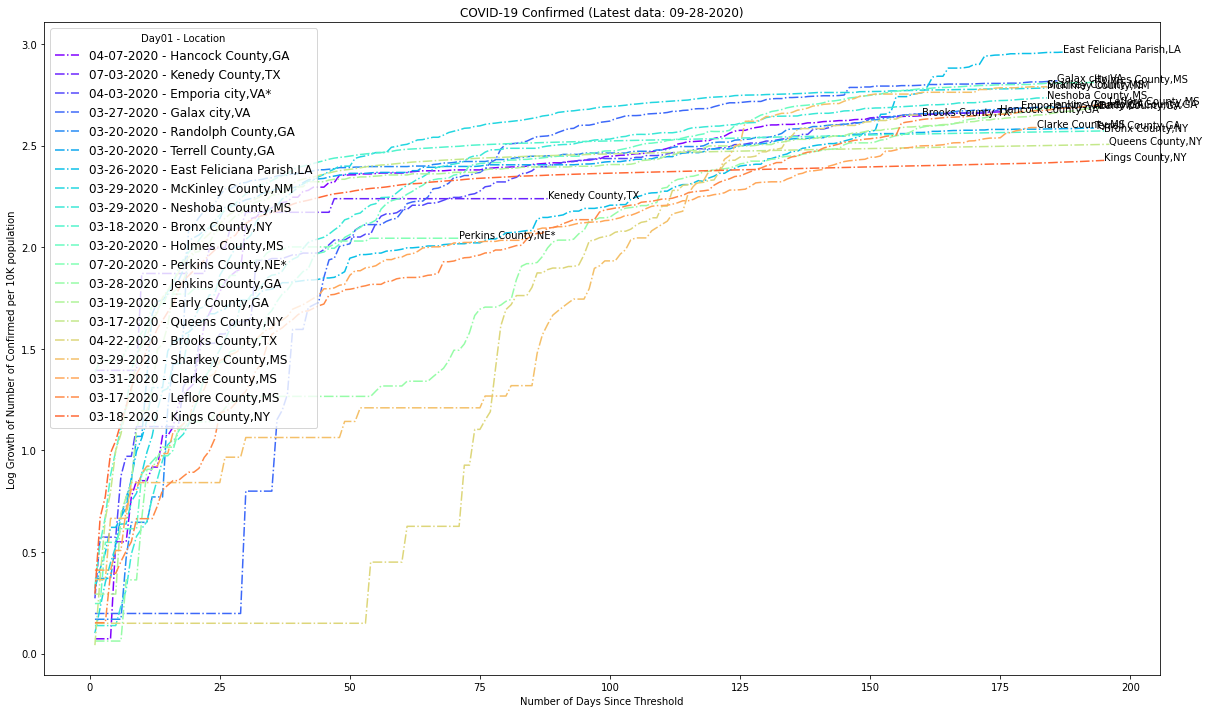

In [411]:
_plot_trend(usaf_county_deaths_trend, us_top_deaths_locs, 'Confirmed')
_plot_log_trend(usaf_county_deaths_trend, us_top_deaths_locs, 'Confirmed')

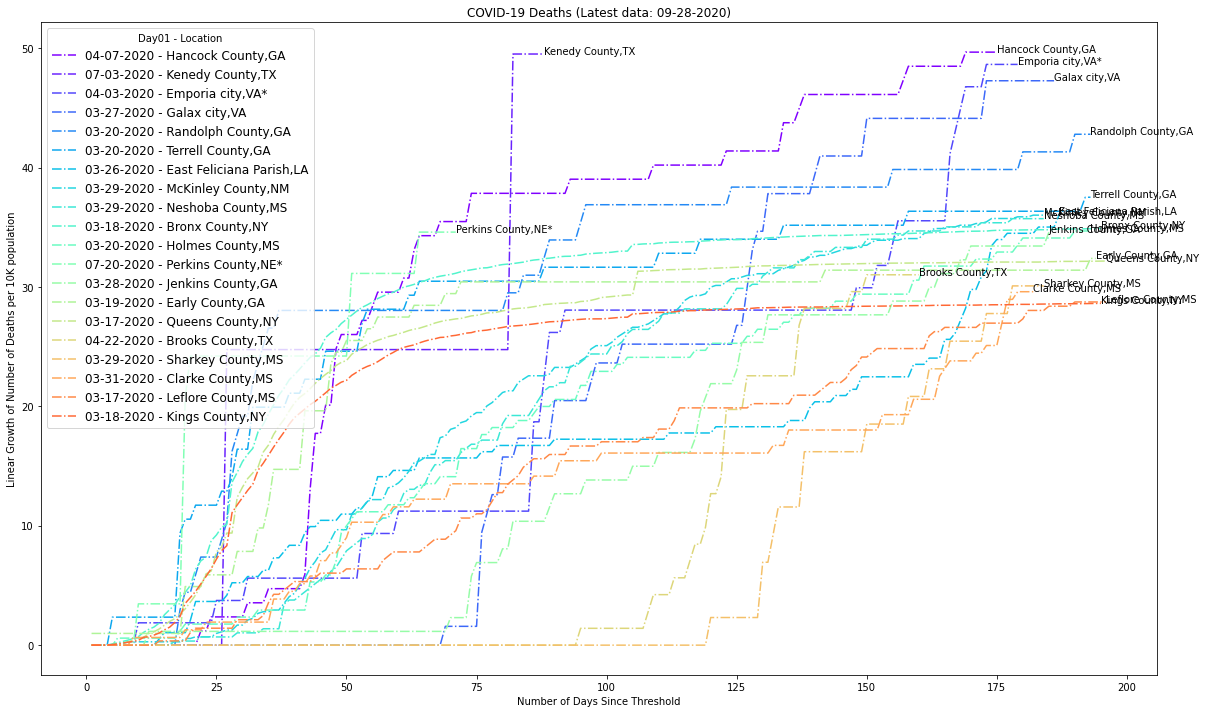

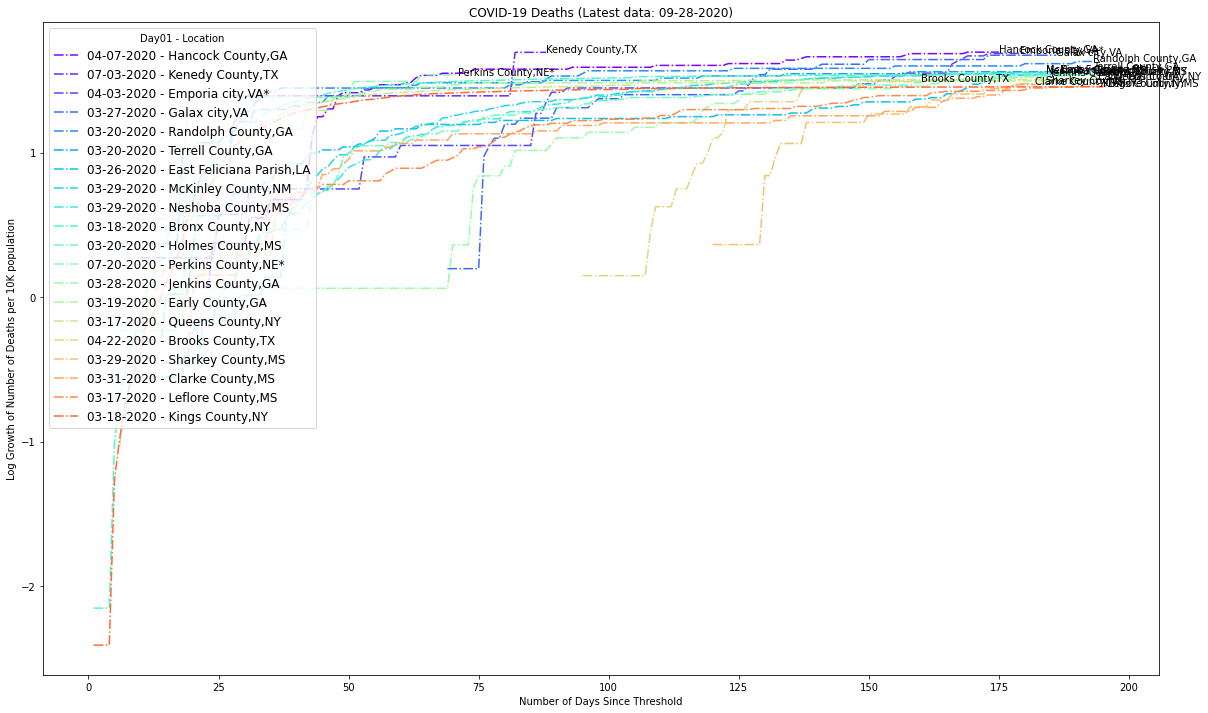

In [412]:
_plot_trend(usaf_county_deaths_trend, us_top_deaths_locs, 'Deaths')
_plot_log_trend(usaf_county_deaths_trend, us_top_deaths_locs, 'Deaths')

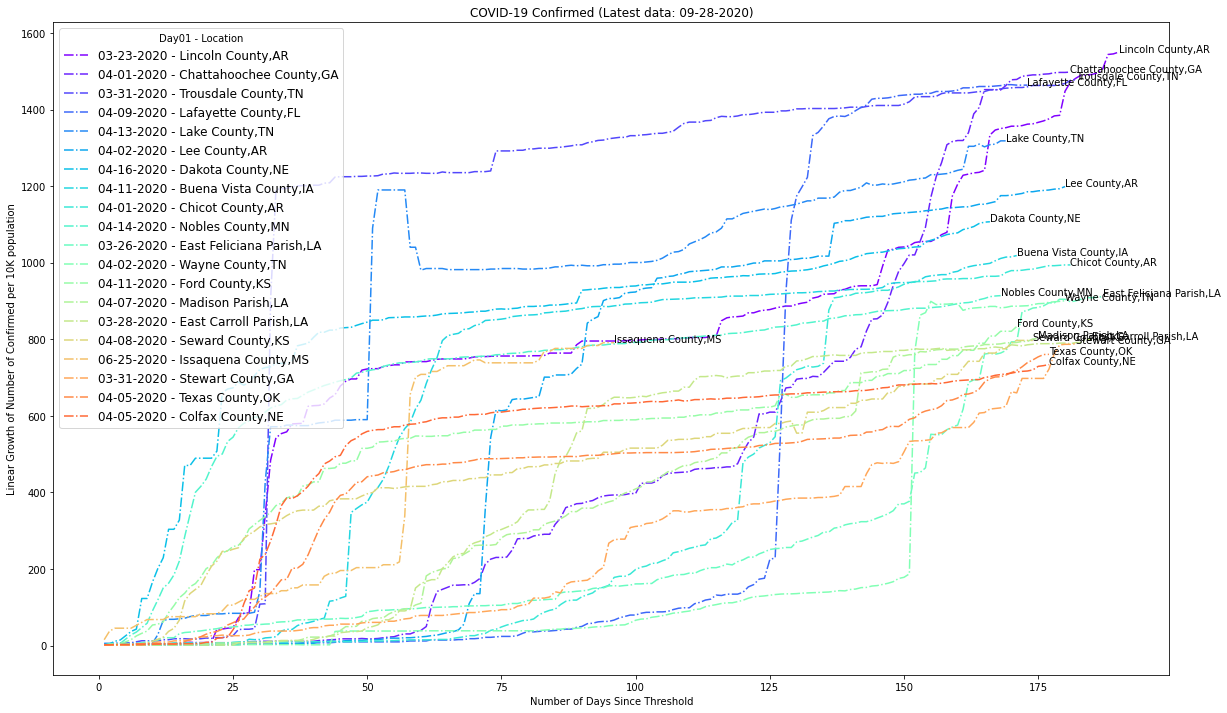

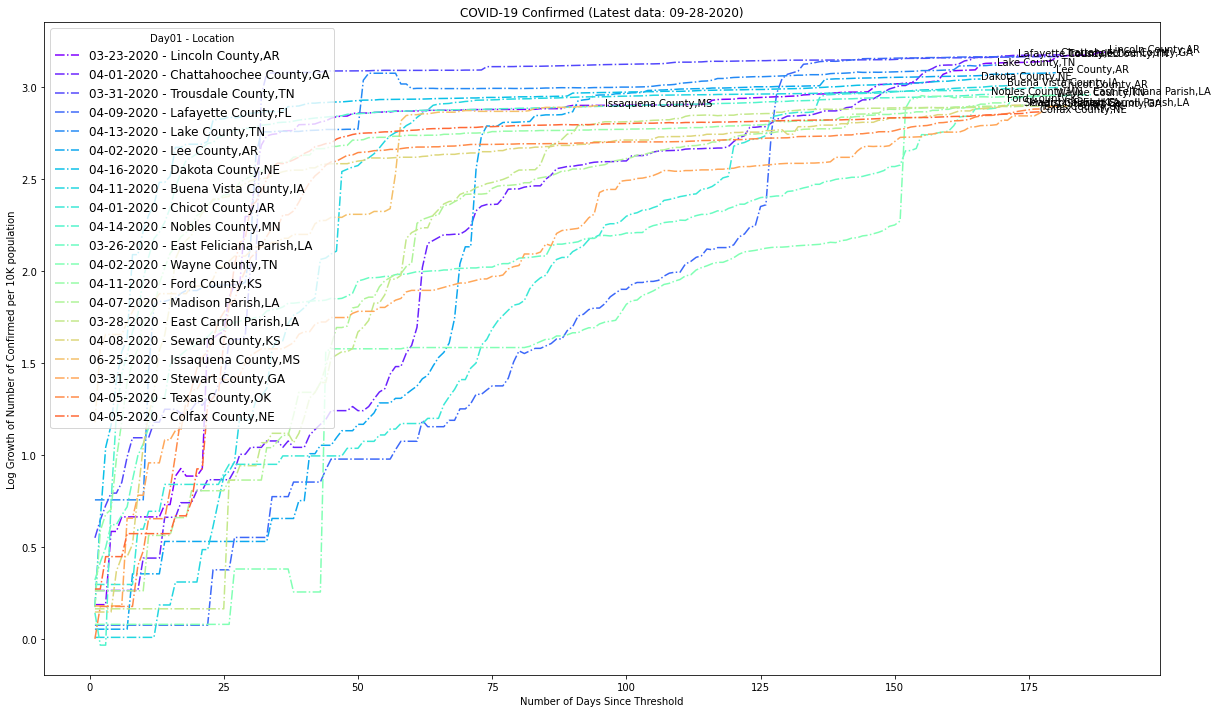

In [413]:
_plot_trend(jh_county_confirmed_trend, us_top_confirmed_locs, 'Confirmed')
_plot_log_trend(jh_county_confirmed_trend, us_top_confirmed_locs, 'Confirmed')

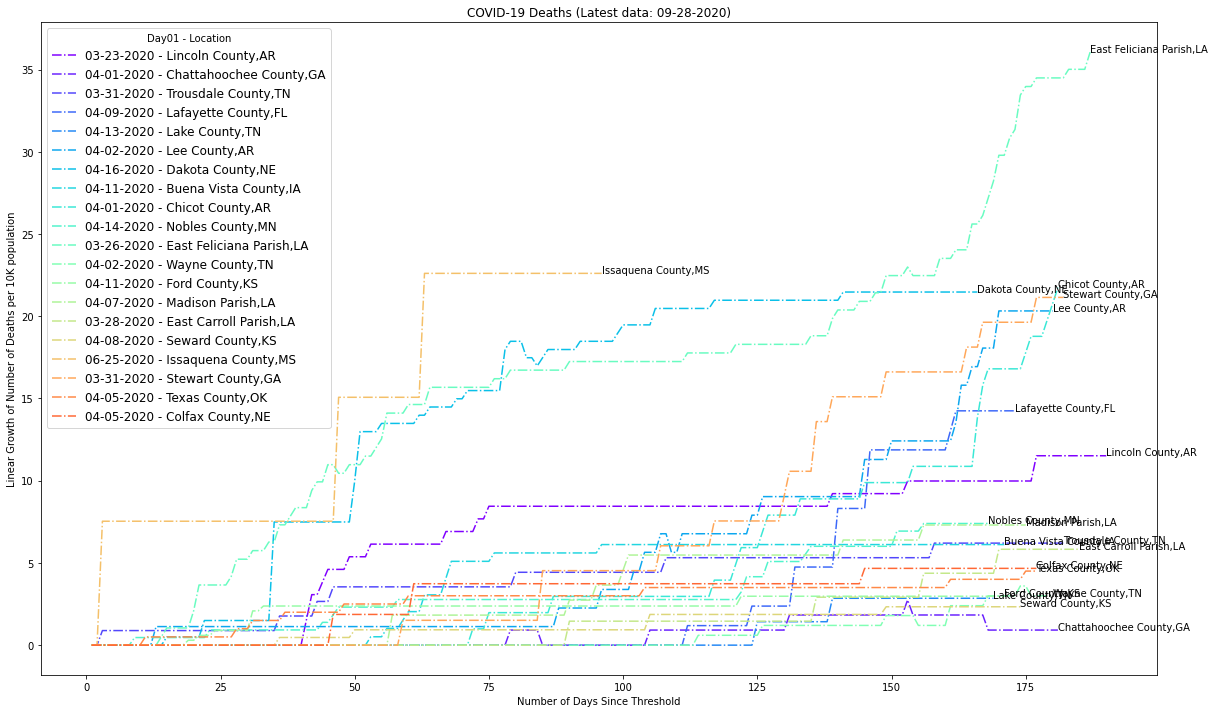

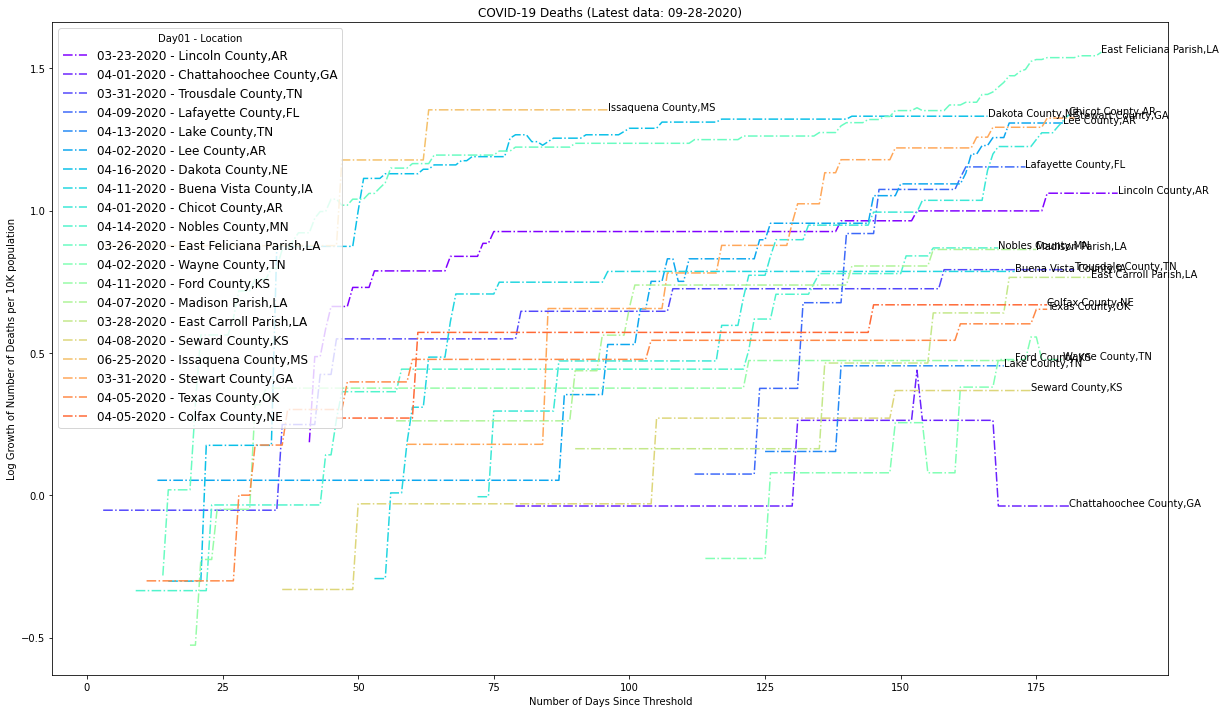

In [414]:
_plot_trend(jh_county_confirmed_trend, us_top_confirmed_locs, 'Deaths')
_plot_log_trend(jh_county_confirmed_trend, us_top_confirmed_locs, 'Deaths')

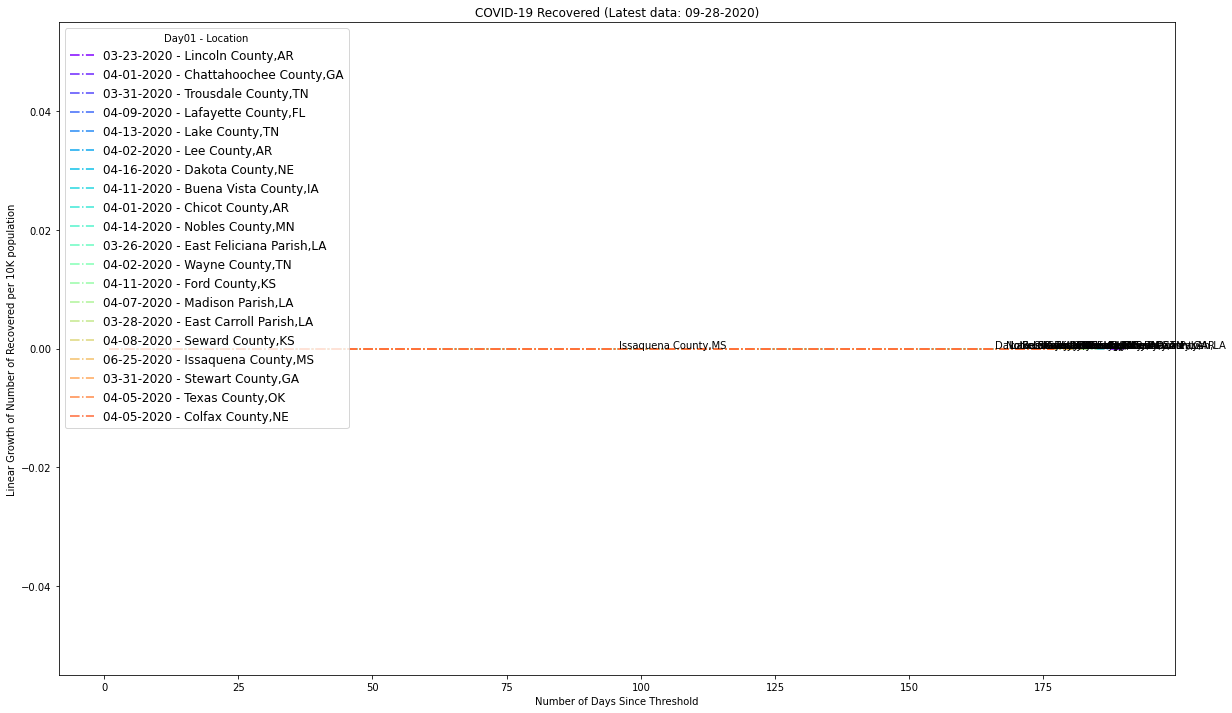

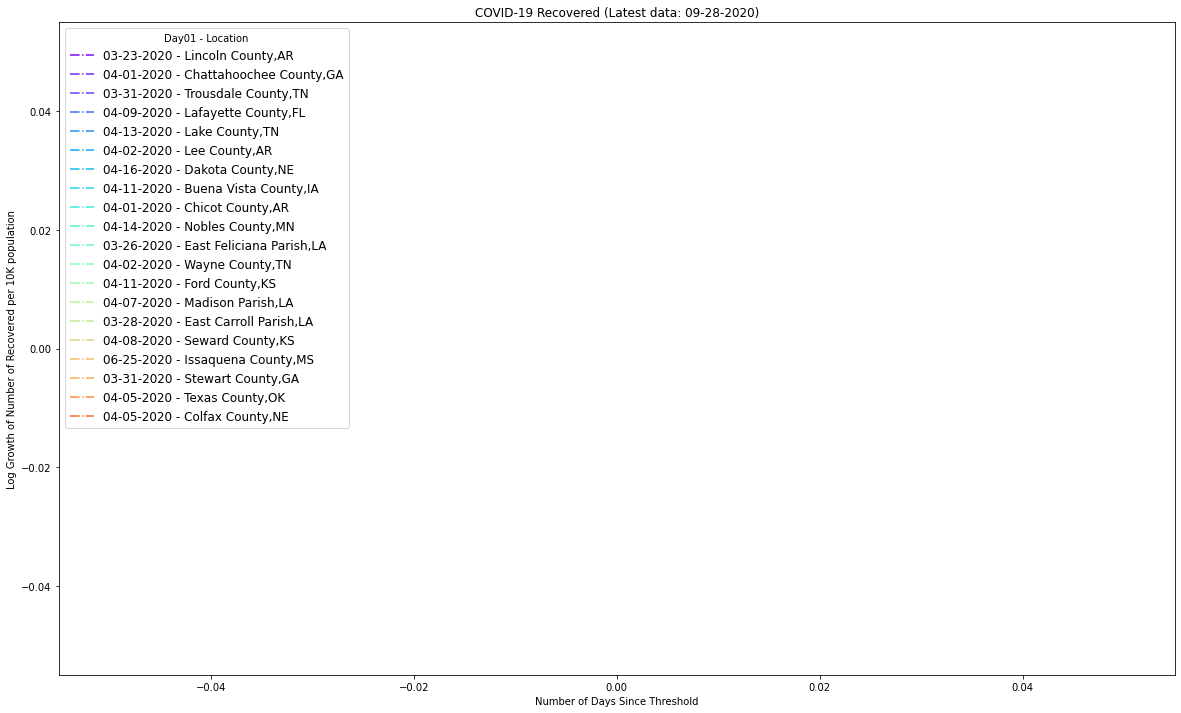

In [415]:
_plot_trend(jh_county_confirmed_trend, us_top_confirmed_locs, 'Recovered')
_plot_log_trend(jh_county_confirmed_trend, us_top_confirmed_locs, 'Recovered')

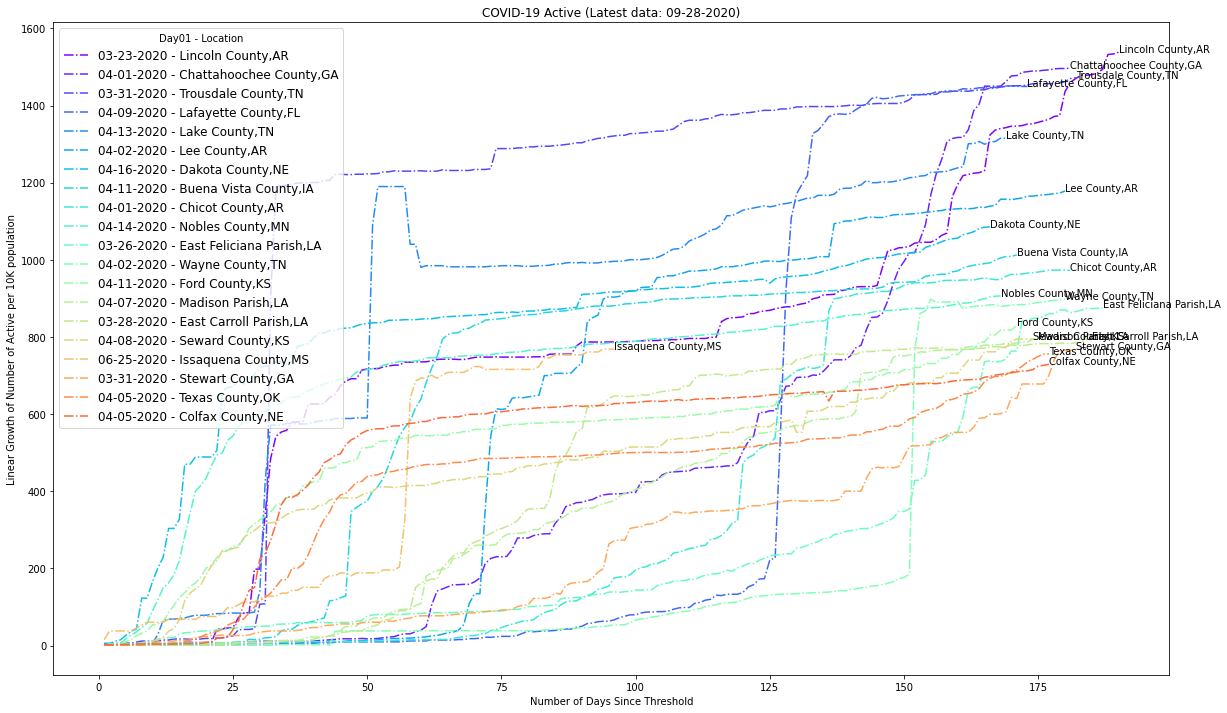

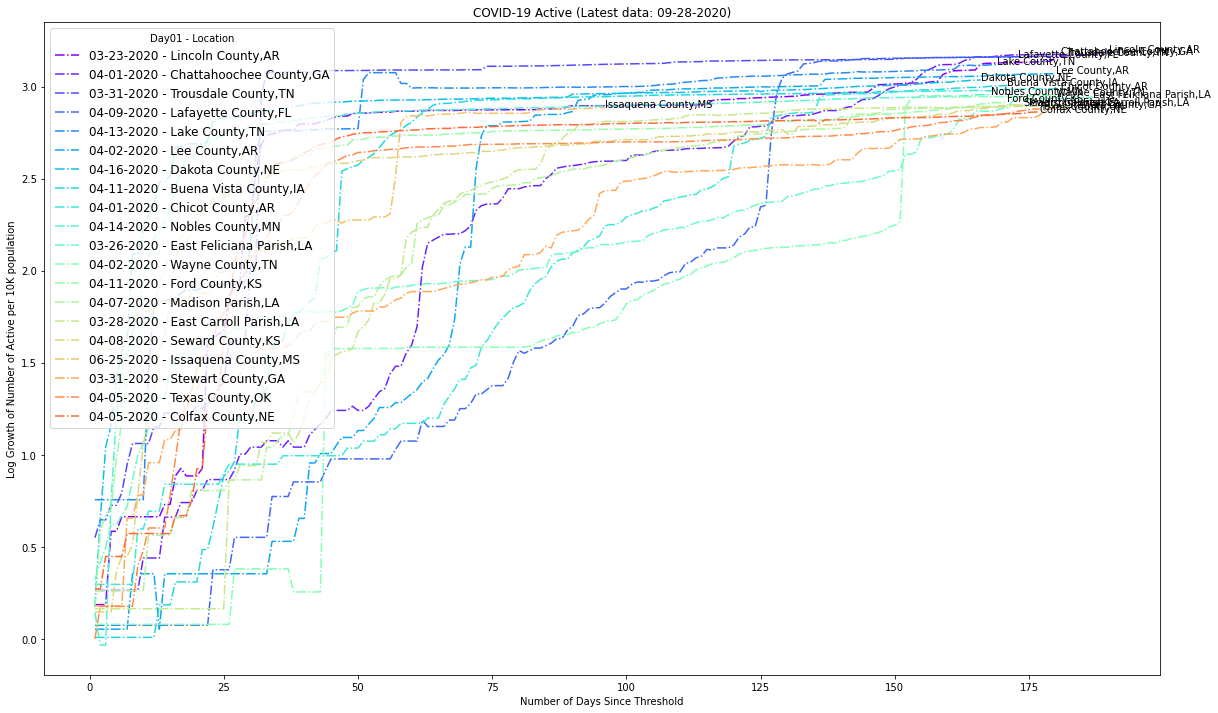

In [416]:
_plot_trend(jh_county_confirmed_trend, us_top_confirmed_locs, 'Active')
_plot_log_trend(jh_county_confirmed_trend, us_top_confirmed_locs, 'Active')

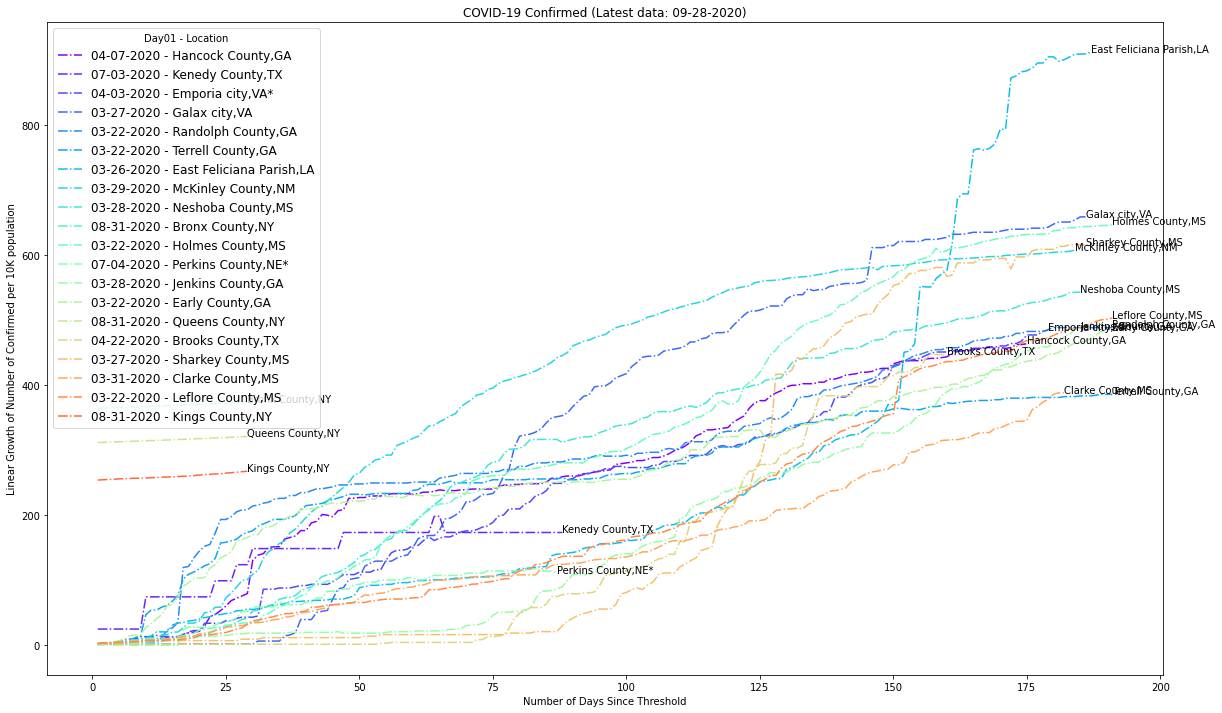

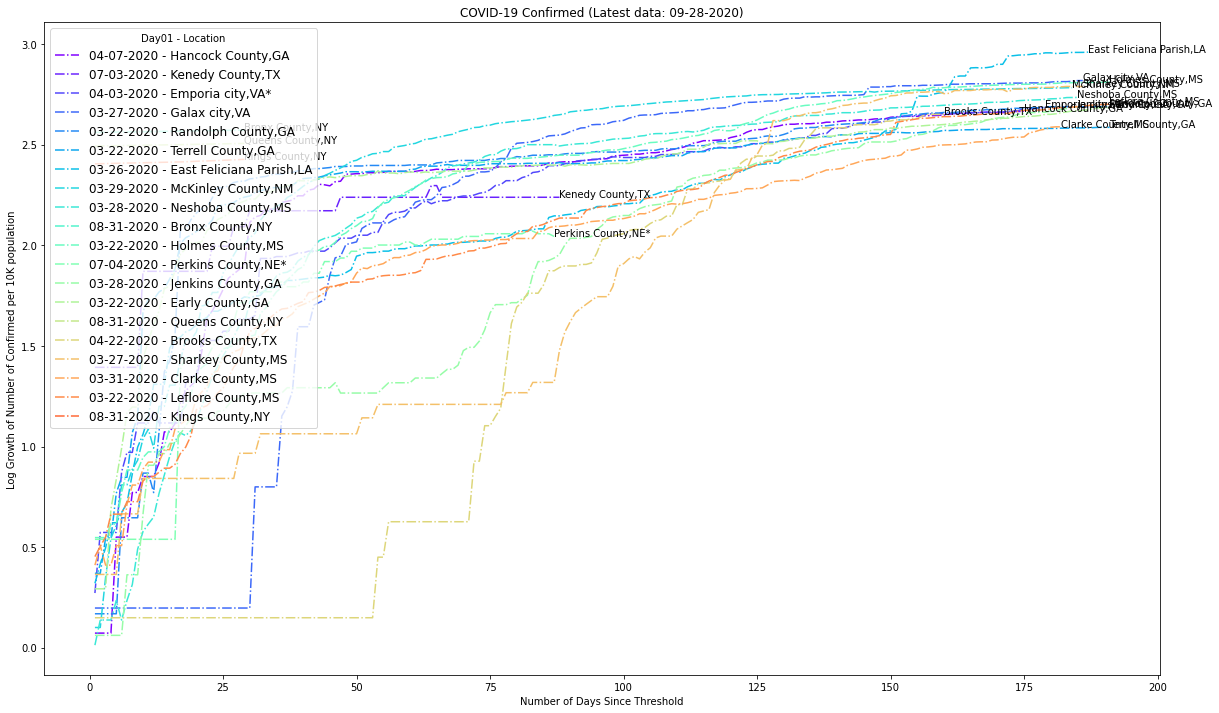

In [417]:
_plot_trend(jh_county_deaths_trend, us_top_deaths_locs, 'Confirmed')
_plot_log_trend(jh_county_deaths_trend, us_top_deaths_locs, 'Confirmed')

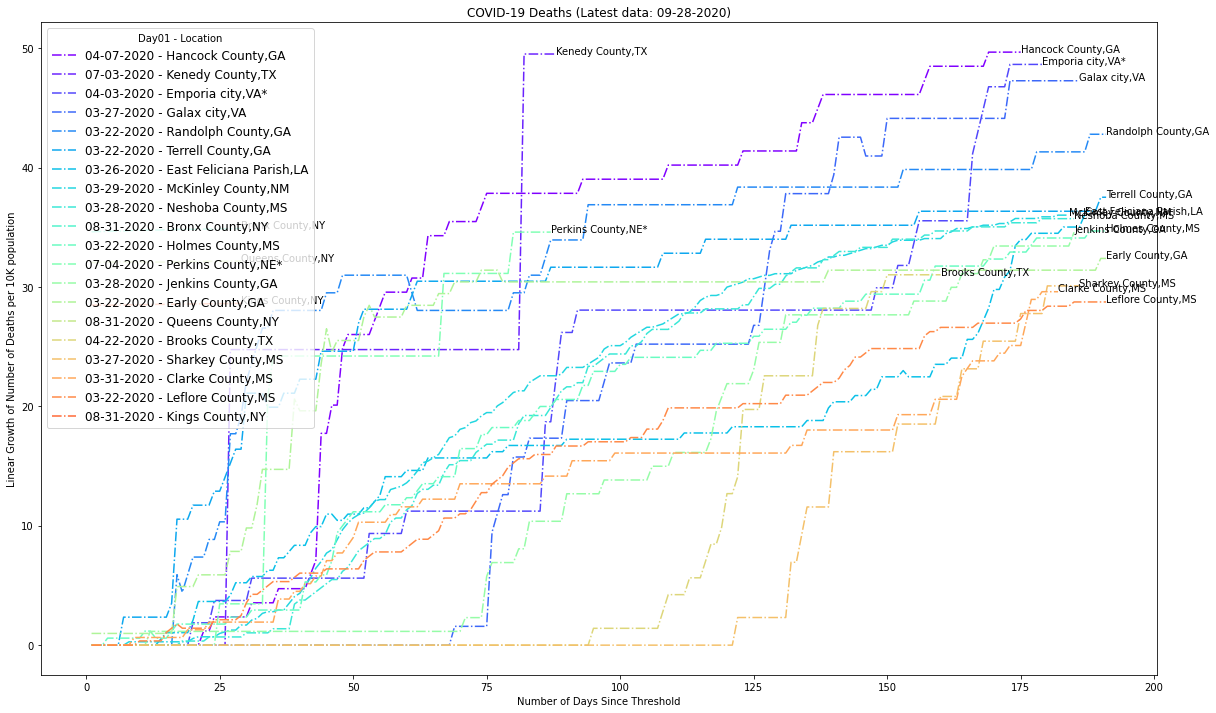

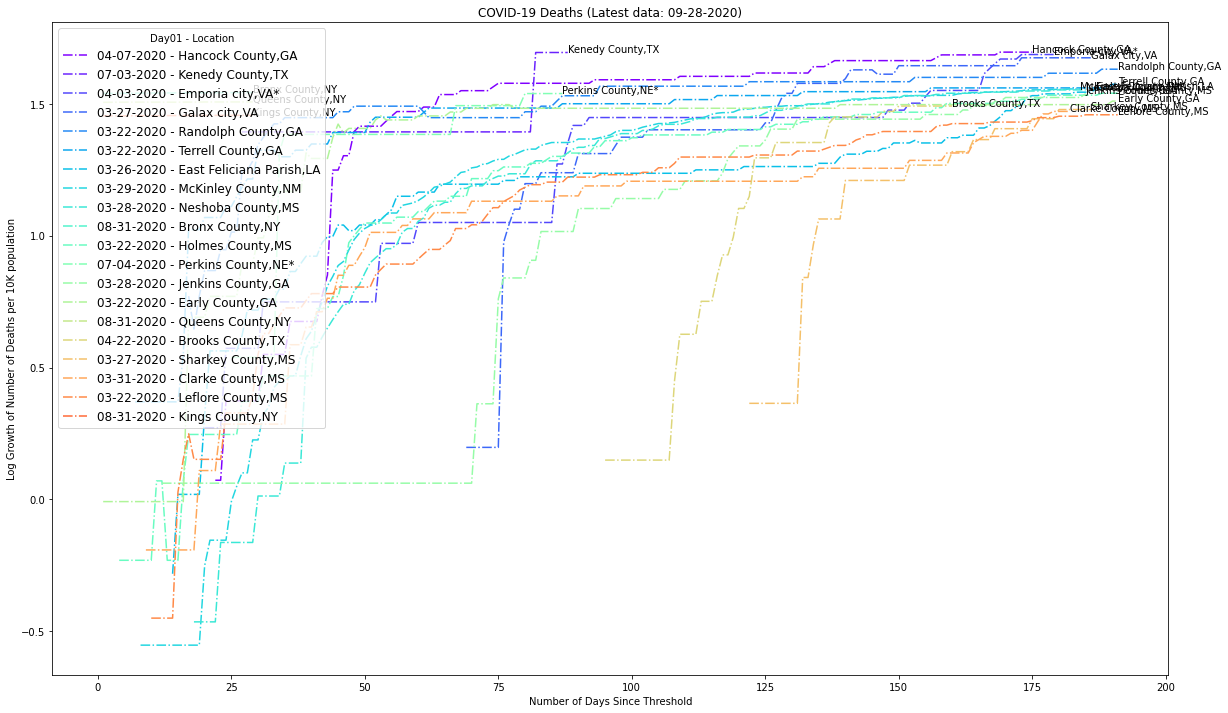

In [418]:
_plot_trend(jh_county_deaths_trend, us_top_deaths_locs, 'Deaths')
_plot_log_trend(jh_county_deaths_trend, us_top_deaths_locs, 'Deaths')

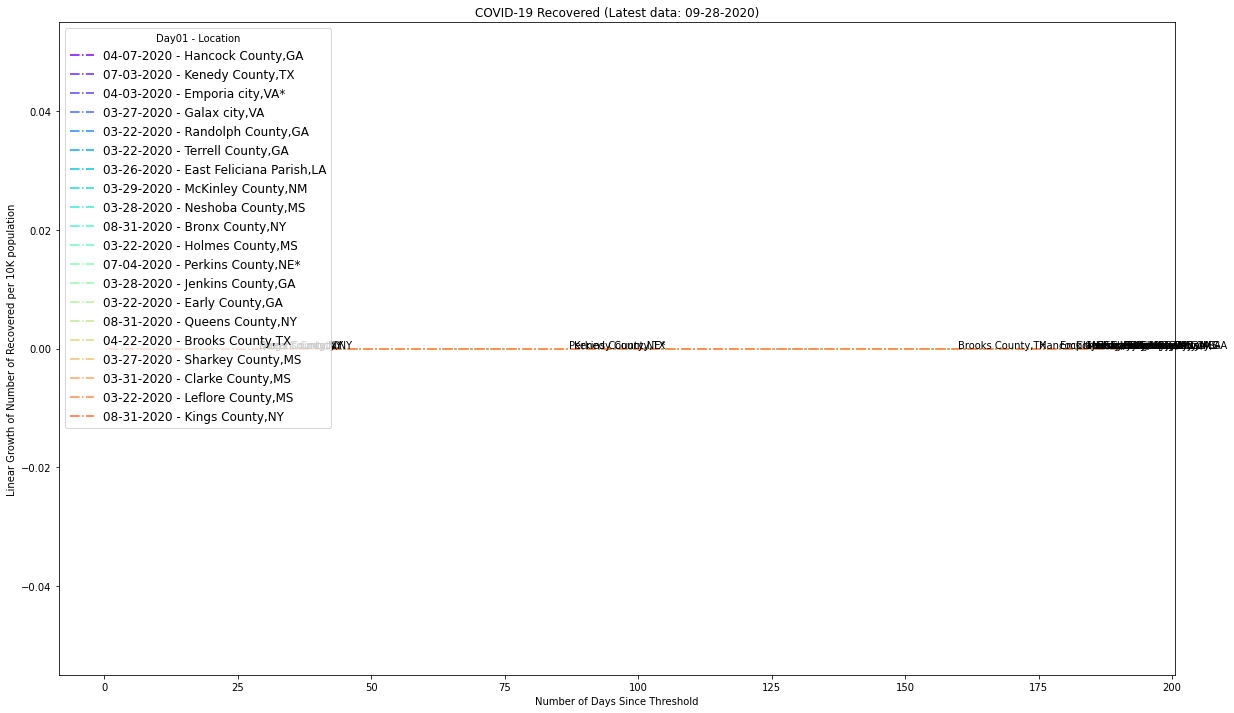

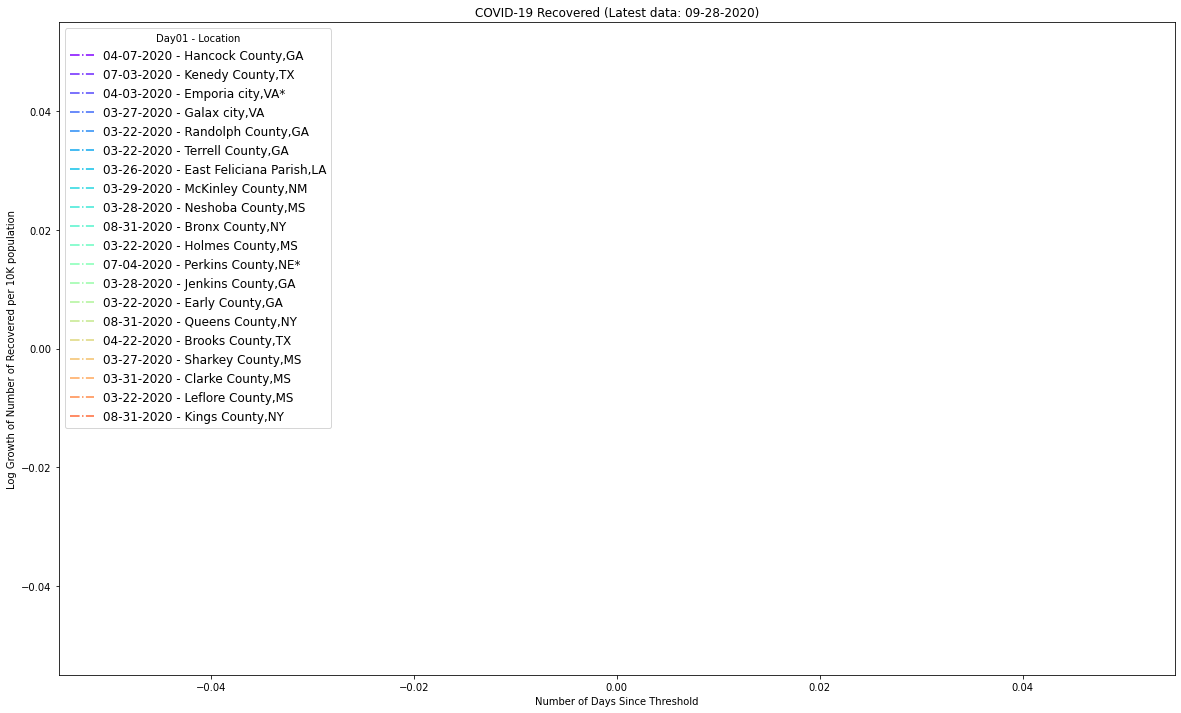

In [419]:
_plot_trend(jh_county_deaths_trend, us_top_deaths_locs, 'Recovered')
_plot_log_trend(jh_county_deaths_trend, us_top_deaths_locs, 'Recovered')

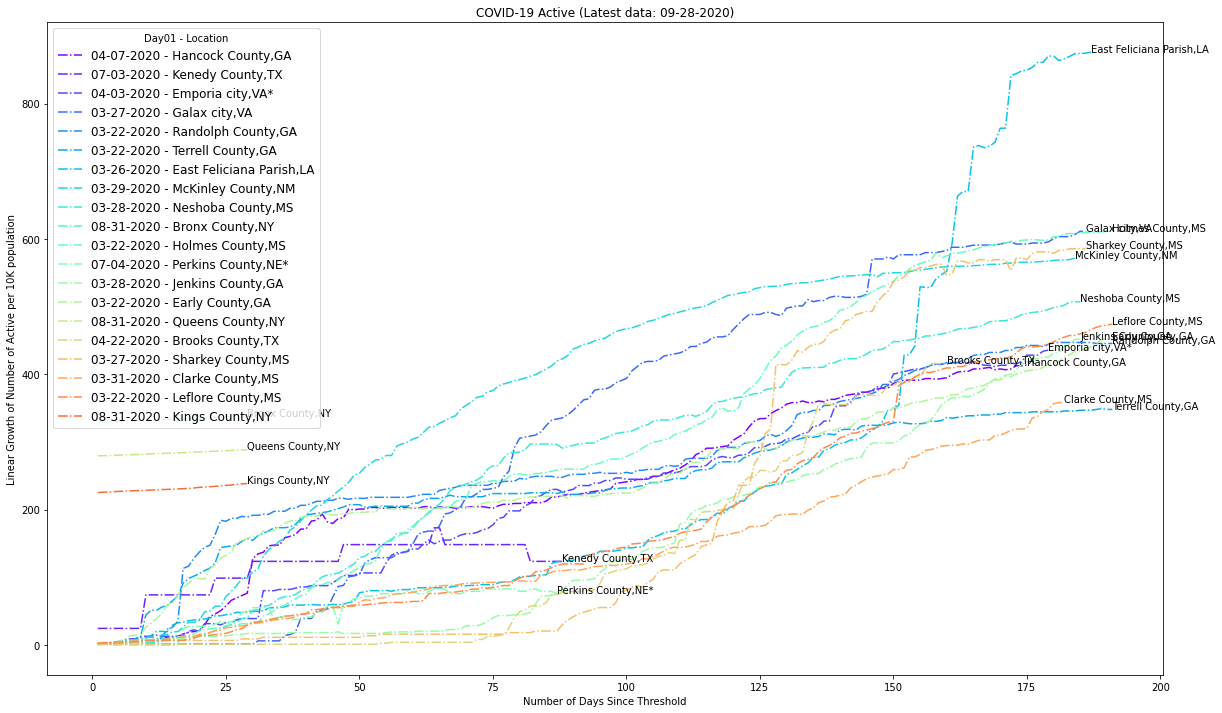

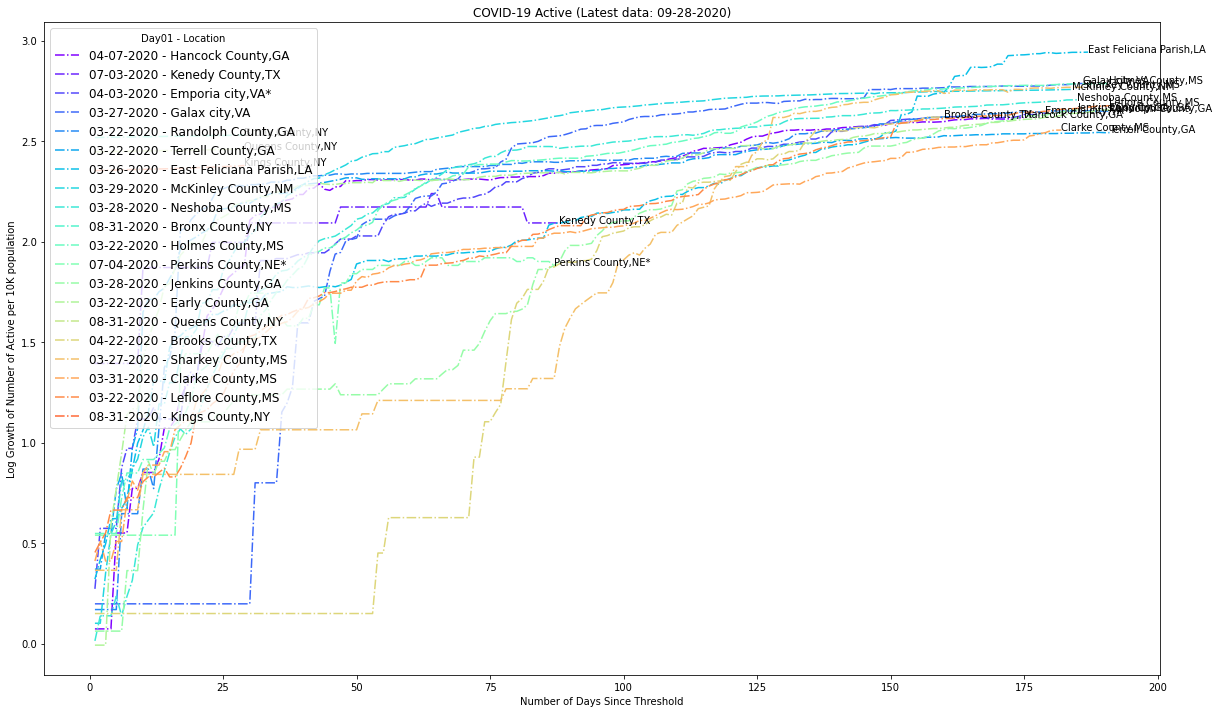

In [420]:
_plot_trend(jh_county_deaths_trend, us_top_deaths_locs, 'Active')
_plot_log_trend(jh_county_deaths_trend, us_top_deaths_locs, 'Active')

# Model Death Trends

In [94]:
us_county_confirmed_report = pd.read_csv('covid_confirmed_usafacts.csv')
us_county_confirmed_report.head(5)

countyFIPS            County Name State  stateFIPS  1/22/20  1/23/20  \
0           0  Statewide Unallocated    AL          1        0        0   
1        1001         Autauga County    AL          1        0        0   
2        1003         Baldwin County    AL          1        0        0   
3        1005         Barbour County    AL          1        0        0   
4        1007            Bibb County    AL          1        0        0   

   1/24/20  1/25/20  1/26/20  1/27/20  ...  10/6/20  10/7/20  10/8/20  \
0        0        0        0        0  ...        0        0        0   
1        0        0        0        0  ...     1839     1852     1863   
2        0        0        0        0  ...     6116     6134     6141   
3        0        0        0        0  ...      923      927      927   
4        0        0        0        0  ...      691      703      708   

   10/9/20  10/10/20  10/11/20  10/12/20  10/13/20  10/14/20  10/15/20  
0        0         0         0         0         0         0         0  
1     1882      1898      1905      1911      1924      1928      1949  
2     6172      6190      6203      6220      6248      6270      6285  
3      939       942       942       944       950       950       965  
4      719       726       736       738       744       744       761  

[5 rows x 272 columns]

In [204]:
county = us_county_confirmed_report
WAKE_CO_FIPS = county[county['County Name'] == 'Wake County']['countyFIPS'].values[0]   # Get Wake, NC county FIPS
NC_FIPS = county[county['County Name'] == 'Wake County']['stateFIPS'].values[0]   # Get Wake, NC county FIPS
print(f'Wake county FIPS = {WAKE_CO_FIPS}, NC FIPS = {NC_FIPS}')

Wake county FIPS = 37183, NC FIPS = 37


In [100]:
print(us_county_confirmed_report['State'][235])
#temp = us_county_confirmed_report.iloc[:, [0,3]].copy()
temp = us_county_confirmed_report.copy().drop(['County Name', 'State'], axis=1)
temp.head()


CA


countyFIPS  stateFIPS  1/22/20  1/23/20  1/24/20  1/25/20  1/26/20  \
0           0          1        0        0        0        0        0   
1        1001          1        0        0        0        0        0   
2        1003          1        0        0        0        0        0   
3        1005          1        0        0        0        0        0   
4        1007          1        0        0        0        0        0   

   1/27/20  1/28/20  1/29/20  ...  10/6/20  10/7/20  10/8/20  10/9/20  \
0        0        0        0  ...        0        0        0        0   
1        0        0        0  ...     1839     1852     1863     1882   
2        0        0        0  ...     6116     6134     6141     6172   
3        0        0        0  ...      923      927      927      939   
4        0        0        0  ...      691      703      708      719   

   10/10/20  10/11/20  10/12/20  10/13/20  10/14/20  10/15/20  
0         0         0         0         0         0         0  
1      1898      1905      1911      1924      1928      1949  
2      6190      6203      6220      6248      6270      6285  
3       942       942       944       950       950       965  
4       726       736       738       744       744       761  

[5 rows x 270 columns]

In [ ]:
### Convert values to new confirmed from total confirmed

In [144]:
new = temp.copy()
for i  in range(3, len(temp.columns)):
    col = temp.columns[i]
    prev = temp.columns[i-1]
    new[col] = temp[col] - temp[prev]
# Check that everything looks good by verifying second row sum
print(new.iloc[1:, 2:len(temp.columns)].loc[1].sum())
new.head()

1949


countyFIPS  stateFIPS  1/22/20  1/23/20  1/24/20  1/25/20  1/26/20  \
0           0          1        0        0        0        0        0   
1        1001          1        0        0        0        0        0   
2        1003          1        0        0        0        0        0   
3        1005          1        0        0        0        0        0   
4        1007          1        0        0        0        0        0   

   1/27/20  1/28/20  1/29/20  ...  10/6/20  10/7/20  10/8/20  10/9/20  \
0        0        0        0  ...        0        0        0        0   
1        0        0        0  ...        8       13       11       19   
2        0        0        0  ...       31       18        7       31   
3        0        0        0  ...        2        4        0       12   
4        0        0        0  ...        4       12        5       11   

   10/10/20  10/11/20  10/12/20  10/13/20  10/14/20  10/15/20  
0         0         0         0         0         0         0  
1        16         7         6        13         4        21  
2        18        13        17        28        22        15  
3         3         0         2         6         0        15  
4         7        10         2         6         0        17  

[5 rows x 270 columns]

In [179]:
transposed = new.melt(id_vars=["countyFIPS", "stateFIPS"],  var_name="Day", value_name="Confirmed")
total_confirmed = transposed.sort_values('Confirmed')['Confirmed'].sum()  # Total US confirmed cases as of Oct 15, 2020 
print(transposed.head())
print(f'\nTotal confirmed cases as of {new.columns[len(new.columns)-1]}: {total_confirmed}')

   countyFIPS  stateFIPS      Day  Confirmed
0           0          1  1/22/20          0
1        1001          1  1/22/20          0
2        1003          1  1/22/20          0
3        1005          1  1/22/20          0
4        1007          1  1/22/20          0

Total confirmed cases as of 10/15/20: 7914517


In [184]:
# Convert Dates to Days since start
days = transposed.copy()
basedate = pd.Timestamp(new.columns[2])
days['Day'] = pd.to_datetime(days['Day'])
days['Day'] = (days['Day'] - basedate).dt.days
#days['Date'] = transposed['Date'] - Date('1/22/20')
days.tail()

countyFIPS  stateFIPS  Day  Confirmed
856255       56037         56  267          4
856256       56039         56  267          1
856257       56041         56  267          3
856258       56043         56  267          0
856259       56045         56  267          5

In [185]:
print(f'Total sample length (number of rows) = {len(transposed)}')

Total sample length (number of rows) = 856260


### Create Test and Train datasets

In [310]:
from sklearn.model_selection import train_test_split

# Create our feature set and our target set, with the target being the 'Comfirmed' column
X = days.drop('Confirmed', axis=1)
y = days['Confirmed']
# Split the data into training and testing with test size of 5% ~= 42,500 samples
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.05, shuffle=True)
print(f'Test length: {len(X_test)}')
pd.DataFrame(X_train, columns=X.columns).tail()

Test length: 42813


countyFIPS  stateFIPS  Day
813442       54019         54  140
813443       27123         27   71
813444       31011         31  156
813445       46107         46  208
813446       27165         27  185

In [208]:
print(days[days['countyFIPS'] == WAKE_CO_FIPS][days['Day'] == 254])
FRIDAY_ACTUAL = 120

        countyFIPS  stateFIPS  Day  Confirmed
813547       37183         37  254        136


<ipython-input-208-c704a5a2cb2a>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(days[days['countyFIPS'] == WAKE_CO_FIPS][days['Day'] == 254])


## CatBoost Model

In [222]:
from catboost import CatBoostRegressor, Pool

eval_dataset = Pool(X_test,y_test)
#for i in range(16):
i = 10
catregress = CatBoostRegressor(learning_rate=0.03, task_type="GPU", depth=i, loss_function='RMSE') # Max depth is 16
cat_model = catregress.fit(X_train, y_train, eval_set=eval_dataset, verbose=0)


In [223]:
print(f'Score for depth {i} = {cat_model.get_best_score()}')
print(cat_model.get_params())

Score for depth 10 = {'learn': {'RMSE': 58.92511899370323}, 'validation': {'RMSE': 54.760017098153845}}
{'learning_rate': 0.03, 'depth': 10, 'loss_function': 'RMSE', 'task_type': 'GPU'}


In [255]:
# Predict number of new cases for Wake County on Friday 10/16/2020 (Day 255)
def evaluate_model(model, X_eval, y_eval):
    pred = model.predict(X_eval)
    actual = 120  # https://coronavirus.jhu.edu/us-map
    accuracy =  (pred / y_eval) * 100
    print(f'Predicted: {pred}   Actual: {actual}   Accuracy: {accuracy}%')

In [246]:
X_eval = [WAKE_CO_FIPS, NC_FIPS, 254]
evaluate_model(cat_model, X_eval, 120)

Predicted: 14.349448451201908   Actual: 120   Accuracy: 11.96%


## Normalized Data

In [312]:
from sklearn.preprocessing import OneHotEncoder

county_norm = pd.get_dummies(X['countyFIPS'])
state_norm = pd.get_dummies(X['stateFIPS'])
county_norm = county_norm.astype(np.float16)  # models like floats and smaller types = faster training
state_norm = state_norm.astype(np.float16)
print(county_norm.head())
print(state_norm.head())

   0      1      1001   1003   1005   1007   1009   1011   1013   1015   ...  \
0    1.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  ...   
1    0.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  ...   
2    0.0    0.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0    0.0  ...   
3    0.0    0.0    0.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0  ...   
4    0.0    0.0    0.0    0.0    0.0    1.0    0.0    0.0    0.0    0.0  ...   

   56027  56029  56031  56033  56035  56037  56039  56041  56043  56045  
0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  
1    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  
2    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  
3    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  
4    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  

[5 rows x 3146 columns]
    1    2    4    5    6    8    9    10   11   1

In [318]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
y_float = y.astype(np.float32)
print(y_float)
#y_reshaped = y_reshaped.values.reshape(1, -1)
#print(y_reshaped)
day_confirmed_norm = pd.DataFrame(scaler.fit_transform(days[['Day','Confirmed']]), columns=['Day','Confirmed'])
print(f'{day_confirmed_norm}')

0        -0.743352
1        -0.743352
2        -0.743352
3        -0.743352
4        -0.743352
            ...   
856255   -0.742859
856256   -0.743229
856257   -0.742982
856258   -0.743352
856259   -0.742736
Name: Confirmed, Length: 856260, dtype: float32
        Day  Confirmed
0      -1.0  -0.743352
1      -1.0  -0.743352
2      -1.0  -0.743352
3      -1.0  -0.743352
4      -1.0  -0.743352
...     ...        ...
856255  1.0  -0.742859
856256  1.0  -0.743229
856257  1.0  -0.742982
856258  1.0  -0.743352
856259  1.0  -0.742736

[856260 rows x 2 columns]


In [321]:
normalized = pd.concat([county_norm, state_norm, day_confirmed_norm], axis=1)
normalized.head()

0    1  1001  1003  1005  1007  1009  1011  1013  1015  ...   48   49  \
0  1.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...  0.0  0.0   
1  0.0  0.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...  0.0  0.0   
2  0.0  0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0  ...  0.0  0.0   
3  0.0  0.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0  ...  0.0  0.0   
4  0.0  0.0   0.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0  ...  0.0  0.0   

    50   51   53   54   55   56  Day  Confirmed  
0  0.0  0.0  0.0  0.0  0.0  0.0 -1.0  -0.743352  
1  0.0  0.0  0.0  0.0  0.0  0.0 -1.0  -0.743352  
2  0.0  0.0  0.0  0.0  0.0  0.0 -1.0  -0.743352  
3  0.0  0.0  0.0  0.0  0.0  0.0 -1.0  -0.743352  
4  0.0  0.0  0.0  0.0  0.0  0.0 -1.0  -0.743352  

[5 rows x 3199 columns]

## Create Train and test sets again (WE SHOULD REFACTOR. NOT COPY/PASTE HERE)

In [322]:
X = normalized.drop('Confirmed', axis=1)
y = normalized['Confirmed']
# Split the data into training and testing with test size of 5% ~= 42,500 samples
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.05, shuffle=True)
pd.DataFrame(X_train, columns=X.columns).tail()

0    1  1001  1003  1005  1007  1009  1011  1013  1015  ...   47  \
813442  0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...  0.0   
813443  0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...  1.0   
813444  1.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...  0.0   
813445  0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...  0.0   
813446  0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...  0.0   

         48   49   50   51   53   54   55   56       Day  
813442  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.797753  
813443  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.138577  
813444  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.003745  
813445  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0 -0.086142  
813446  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 -0.872659  

[5 rows x 3198 columns]

In [323]:
eval_dataset = Pool(X_test,y_test)

## CatBoost on Normalzied Data

In [324]:
catregress = CatBoostRegressor(learning_rate=0.03, task_type="GPU", depth=i, loss_function='RMSE') # Max depth is same
cat_model = catregress.fit(X_train, y_train, eval_set=eval_dataset, verbose=0)

In [326]:
print(f'Score for depth {i} = {cat_model.get_best_score()}')

Score for depth 10 = {'learn': {'RMSE': 0.005351621125025099}, 'validation': {'RMSE': 0.00743479020792178}}


In [402]:
X_eval = pd.DataFrame(X_train,columns=X.columns)[0:1].copy()  # Grab the first row
X_eval[X_eval > 0.0] = 0.0  # Reset it to zeros
X_eval[WAKE_CO_FIPS] = 1.0  # Mark the countyFIPs as Wake County
X_eval[NC_FIPS] = 1.0  # Mark the stateFIPs as NC

eval_scaled = scaler.transform([[254.0, 120.0]])[0]
# print(eval_scaled)
X_eval['Day'] = eval_scaled[0]  # Mark the day as Friday 10/16/2020
# print(X_eval)
y_eval = eval_scaled[1]
scaled_result = cat_model.predict(X_eval.values)
descaled_result = scaler.inverse_transform([[scaled_result, 0.0]])[0]
descaled_result = int(descaled_result[0])
# print(descaled_result)
actual = 120  # https://coronavirus.jhu.edu/us-map
accuracy =  (descaled_result / actual) * 100
print(f'Predicted: {descaled_result}   Actual: {actual}   Accuracy: {accuracy:.2f}%')

Predicted: 34   Actual: 120   Accuracy: 28.33%


## TPOT AutoML

In [237]:
from tpot import TPOTClassifier, TPOTRegressor

C:\Users\Chris\anaconda3\envs\hr\lib\site-packages\tpot\builtins\__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")


In [239]:
tpot = TPOTRegressor(generations=20, population_size=200, cv=5, random_state=42, verbosity=2, early_stop=2, max_time_mins=45, memory='auto', n_jobs=-1)
tpot.fit(X_train, y_train.ravel())


45.26 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: GradientBoostingRegressor(input_matrix, alpha=0.99, learning_rate=0.5, loss=ls, max_depth=6, max_features=0.6500000000000001, min_samples_leaf=19, min_samples_split=2, n_estimators=100, subsample=0.5)


TPOTRegressor(early_stop=2, generations=20,
              log_file=<ipykernel.iostream.OutStream object at 0x000001B5A3D75610>,
              max_time_mins=45, memory='auto', n_jobs=-1, population_size=200,
              random_state=42, verbosity=2)

In [259]:
tpot_best = tpot.fitted_pipeline_.steps[-1][1]
tpot_history = tpot_best.fit(X_train, y_train)
tpot_best.score(X_test, y_test)

0.6875702579195406

In [260]:
y_eval = np.array([254])
X_eval_r = np.array(X_eval).reshape(1, -1)
evaluate_model(tpot_best, X_eval_r, y_eval.reshape(1, -1))

Predicted: [64.91170678]   Actual: 120   Accuracy: [[25.55579007]]%
